# 8. Evaluation of First Order Explanations

This notebook, part of the analysis phase of the project, is devoted to evaluating the generated first order explanations using the proposed metrics.

In [ ]:
# Necessary imports
import polars as pl
import pickle
import sys
import numpy as np

import torch
import regex as re

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from tqdm import tqdm
from tqdm.auto import tqdm as tqdma

from wordcloud import WordCloud
from nltk.corpus import stopwords

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
)

from nltk import Tree
import stanza

# Get the absolute path of the project's root directory
ROOT_DIR = Path.resolve(Path.cwd() / "../")

# Add root directory to sys.path
sys.path.append(str(ROOT_DIR))

from src.utils.set_seed import set_seed
from src.utils.expl_utils import (
    get_shap_explanations,
    get_idg_explanations,
    get_ig_explanations,
    get_rationales,
    agreement_at_k,
    check_attribution_tokens,
    check_label,
    precision_recall_curve,
    compute_comprehensiveness,
    compute_sufficiency,
    predict_sample,
)

# Set the seed for reproducibility
rng = set_seed()

import sklearn
from sklearnex import patch_sklearn

patch_sklearn()

mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["text.latex.preamble"] = r"\usepackage{mathpazo}"


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
2025-06-07 22:28:46.999714: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-07 22:28:47.008337: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-07 22:28:47.018192: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-07 22:28:47.021691: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has al

In [ ]:
# Directory management
DATA_DIR = ROOT_DIR / "data"
SPLITTED_DATA_DIR = DATA_DIR / "splitted"

MODELS_DIR = ROOT_DIR / "models"

OUTPUT_DIR = ROOT_DIR / "output"

IG_DIR = OUTPUT_DIR / "integrated_gradients"
TREES_DIR = OUTPUT_DIR / "constituency_trees"
IDG_DIR = OUTPUT_DIR / "integrated_directional_gradients"
SHAP_DIR = OUTPUT_DIR / "shap"
LIME_DIR = OUTPUT_DIR / "lime"

EVALUATION_DIR = OUTPUT_DIR / "evaluation"

FIGURES_DIR = ROOT_DIR / "etc/figures"


In [3]:
# Load the dataset
df_test_trees = pl.read_parquet(TREES_DIR / "test_2_classes_with_trees.parquet")


In [4]:
# Load the fine-tuned model and tokenizer
model_clf = AutoModelForSequenceClassification.from_pretrained(
    MODELS_DIR / "bert-base-uncased_2_classes",
)

tokenizer = AutoTokenizer.from_pretrained(
    MODELS_DIR / "bert-base-uncased_2_classes",
)


In [5]:
# Label encoding
label2id = {"normal": 0, "hatespeech": 1}
id2label = {id_: label for label, id_ in label2id.items()}
target_labels = list(label2id.keys())


***

## 8.1. Agreement with Human Rationales (Plausibility)

### 8.1.1. Agreement@k

In [6]:
k_max = 15

guids = df_test_trees["post_id"].to_list()

guids = [
    guid for guid in guids if check_label(df_test_trees, guid, label2id["hatespeech"])
]


#### IDG

In [7]:
agreements_at_k_idg_human = {
    guid: [] for guid in guids
}

for guid in tqdma(guids):
    try:
        # Get the IDG explanation
        idg_expl = get_idg_explanations(IDG_DIR, df_test_trees, guid)
        # Get the rationales
        rationale = get_rationales(df_test_trees, guid)
    except FileNotFoundError:
        print(f"File not found for post {guid}. Skipping...")
        agreements_at_k_idg_human.pop(guid)
        continue
    except ValueError as e:
        raise ValueError(f"ValueError for post {guid}: {e}.") from e


    probs = predict_sample(
        model_clf,
        tokenizer,
        df_test_trees.filter(pl.col("post_id") == guid)["tokens"].to_list()[0],
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    )

    predicted_class = np.argmax(probs)

    true_class = df_test_trees.filter(pl.col("post_id") == guid)["label"].to_list()[0]

    if predicted_class != true_class:
        print(
            f"Predicted class {id2label[predicted_class]} does not match true class {id2label[true_class]} for post {guid}. Skipping...",
        )
        agreements_at_k_idg_human.pop(guid)
        continue
    if predicted_class != label2id["hatespeech"]:
        print(
            f"Predicted class {id2label[predicted_class]} is not hatespeech for post {guid}. Skipping...",
        )
        agreements_at_k_idg_human.pop(guid)
        continue

    # Check if the tokens in the two attribution methods are the same
    check_attribution_tokens(idg_expl, rationale)

    for k in range(1, k_max + 1):
        agreements_at_k_idg_human[guid].append(
            agreement_at_k(idg_expl, rationale, k),
        )


  0%|          | 0/594 [00:00<?, ?it/s]

Predicted class normal does not match true class hatespeech for post 18721090_gab. Skipping...
Predicted class normal does not match true class hatespeech for post 1178723245211734016_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 1178965584488230913_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 1179082312123916292_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 14602552_gab. Skipping...
Predicted class normal does not match true class hatespeech for post 21209681_gab. Skipping...
Predicted class normal does not match true class hatespeech for post 1179007711721279488_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 1179076651834957825_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 7894283_gab. Skipping...
Predicted class normal does not match true class hatespeech for post 11

#### IG

In [8]:
agreements_at_k_ig_human = {
    guid: [] for guid in guids
}

for guid in tqdma(guids):
    try:
        # Get the IDG explanation
        ig_expl = get_ig_explanations(IG_DIR, df_test_trees, guid)
        # Get the rationales
        rationale = get_rationales(df_test_trees, guid)
    except FileNotFoundError:
        print(f"File not found for post {guid}. Skipping...")
        agreements_at_k_ig_human.pop(guid)
        continue
    except ValueError:
        print(f"Processing Error for post {guid}. Skipping...")
        agreements_at_k_ig_human.pop(guid)
        continue
        # raise ValueError(f"ValueError for post {guid}: {e}. Skipping...") from e


    probs = predict_sample(
        model_clf,
        tokenizer,
        df_test_trees.filter(pl.col("post_id") == guid)["tokens"].to_list()[0],
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    )

    predicted_class = np.argmax(probs)

    true_class = df_test_trees.filter(pl.col("post_id") == guid)["label"].to_list()[0]

    if predicted_class != true_class:
        print(
            f"Predicted class {id2label[predicted_class]} does not match true class {id2label[true_class]} for post {guid}. Skipping...",
        )
        agreements_at_k_ig_human.pop(guid)
        continue
    if predicted_class != label2id["hatespeech"]:
        print(
            f"Predicted class {id2label[predicted_class]} is not hatespeech for post {guid}. Skipping...",
        )
        agreements_at_k_ig_human.pop(guid)
        continue

    # Check if the tokens in the two attribution methods are the same
    check_attribution_tokens(ig_expl, rationale)

    for k in range(1, k_max + 1):
        agreements_at_k_ig_human[guid].append(
            agreement_at_k(ig_expl, rationale, k),
        )


  0%|          | 0/594 [00:00<?, ?it/s]

Predicted class normal does not match true class hatespeech for post 18721090_gab. Skipping...
Processing Error for post 1178251992801533952_twitter. Skipping...
Processing Error for post 23377953_gab. Skipping...
Predicted class normal does not match true class hatespeech for post 1178723245211734016_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 1178965584488230913_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 1179082312123916292_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 14602552_gab. Skipping...
Predicted class normal does not match true class hatespeech for post 21209681_gab. Skipping...
Processing Error for post 10177273_gab. Skipping...
Predicted class normal does not match true class hatespeech for post 1179007711721279488_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 1179076651834957825_twitter. Skippi

#### SHAP

In [9]:
agreements_at_k_shap_human = {
    guid: [] for guid in guids
}

for guid in tqdma(guids):
    try:
        # Get the IDG explanation
        shap_expl = get_shap_explanations(SHAP_DIR, df_test_trees, guid)
        # Get the rationales
        rationale = get_rationales(df_test_trees, guid)
    except FileNotFoundError:
        print(f"File not found for post {guid}. Skipping...")
        agreements_at_k_shap_human.pop(guid)
        continue
    except ValueError:
        print(f"Processing Error for post {guid}. Skipping...")
        agreements_at_k_shap_human.pop(guid)
        continue


    probs = predict_sample(
        model_clf,
        tokenizer,
        df_test_trees.filter(pl.col("post_id") == guid)["tokens"].to_list()[0],
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    )

    predicted_class = np.argmax(probs)

    true_class = df_test_trees.filter(pl.col("post_id") == guid)["label"].to_list()[0]

    if predicted_class != true_class:
        print(
            f"Predicted class {id2label[predicted_class]} does not match true class {id2label[true_class]} for post {guid}. Skipping...",
        )
        agreements_at_k_shap_human.pop(guid)
        continue
    if predicted_class != label2id["hatespeech"]:
        print(
            f"Predicted class {id2label[predicted_class]} is not hatespeech for post {guid}. Skipping...",
        )
        agreements_at_k_shap_human.pop(guid)
        continue

    # Check if the tokens in the two attribution methods are the same
    check_attribution_tokens(shap_expl, rationale)

    for k in range(1, k_max + 1):
        agreements_at_k_shap_human[guid].append(
            agreement_at_k(shap_expl, rationale, k),
        )


  0%|          | 0/594 [00:00<?, ?it/s]

Predicted class normal does not match true class hatespeech for post 18721090_gab. Skipping...
Processing Error for post 1178251992801533952_twitter. Skipping...
Processing Error for post 23377953_gab. Skipping...
Predicted class normal does not match true class hatespeech for post 1178723245211734016_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 1178965584488230913_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 1179082312123916292_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 14602552_gab. Skipping...
Predicted class normal does not match true class hatespeech for post 21209681_gab. Skipping...
Processing Error for post 10177273_gab. Skipping...
Predicted class normal does not match true class hatespeech for post 1179007711721279488_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 1179076651834957825_twitter. Skippi

#### Results

In [10]:
guids_idg_human = list(agreements_at_k_idg_human.keys())
guids_ig_human = list(agreements_at_k_ig_human.keys())
guids_shap_human = list(agreements_at_k_shap_human.keys())

common_guids = set(guids_idg_human) & set(guids_ig_human) & set(guids_shap_human)

agreements_at_k_idg_human = {
    guid: agreements_at_k_idg_human[guid]
    for guid in common_guids
}
agreements_at_k_ig_human = {
    guid: agreements_at_k_ig_human[guid]
    for guid in common_guids
}

agreements_at_k_shap_human = {
    guid: agreements_at_k_shap_human[guid]
    for guid in common_guids
}

mean_agreements_at_k_ig_human = {
    k: np.mean([agreements_at_k_ig_human[guid][k -1] for guid in agreements_at_k_ig_human])
    for k in range(1, k_max + 1)
}

mean_agreements_at_k_idg_human = {
    k: np.mean([agreements_at_k_idg_human[guid][k -1] for guid in agreements_at_k_idg_human])
    for k in range(1, k_max + 1)
}

mean_agreements_at_k_shap_human = {
    k: np.mean([agreements_at_k_shap_human[guid][k -1] for guid in agreements_at_k_shap_human])
    for k in range(1, k_max + 1)
}


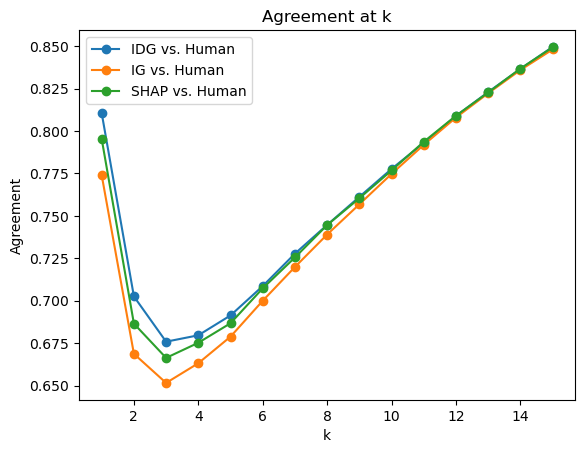

In [11]:
# Plot the results
plt.plot(
    mean_agreements_at_k_idg_human.keys(),
    mean_agreements_at_k_idg_human.values(),
    marker="o",
    label="IDG vs. Human",
)
plt.xlabel("k")
plt.ylabel("Agreement")

plt.plot(
    mean_agreements_at_k_ig_human.keys(),
    mean_agreements_at_k_ig_human.values(),
    marker="o",
    label="IG vs. Human",
)

plt.plot(
    mean_agreements_at_k_shap_human.keys(),
    mean_agreements_at_k_shap_human.values(),
    marker="o",
    label="SHAP vs. Human",
)

plt.title("Agreement at k")
plt.legend()
plt.show()


### 8.1.2. AUPRC

In [12]:
guids = df_test_trees["post_id"].to_list()

guids = [
    guid for guid in guids if check_label(df_test_trees, guid, label2id["hatespeech"])
]


#### IDG

In [13]:
precisions_idg_human = np.array([])
recalls_idg_human = np.array([])
auprcs_idg_human = np.array([])

for guid in tqdma(guids):
    try:
        # Get the IDG explanation
        idg_expl = get_idg_explanations(IDG_DIR, df_test_trees, guid)
        # Get the rationales
        rationale = get_rationales(df_test_trees, guid)
    except FileNotFoundError:
        print(f"File not found for post {guid}. Skipping...")
        continue
    except ValueError as e:
        raise ValueError(f"ValueError for post {guid}: {e}.") from e


    probs = predict_sample(
        model_clf,
        tokenizer,
        df_test_trees.filter(pl.col("post_id") == guid)["tokens"].to_list()[0],
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    )

    predicted_class = np.argmax(probs)

    true_class = df_test_trees.filter(pl.col("post_id") == guid)["label"].to_list()[0]

    if predicted_class != true_class:
        print(
            f"Predicted class {id2label[predicted_class]} does not match true class {id2label[true_class]} for post {guid}. Skipping...",
        )
        continue
    if predicted_class != label2id["hatespeech"]:
        print(
            f"Predicted class {id2label[predicted_class]} is not hatespeech for post {guid}. Skipping...",
        )
        continue

    # Check if the tokens in the two attribution methods are the same
    check_attribution_tokens(idg_expl, rationale)

    precision_idg, recall_idg, auprc_idg = precision_recall_curve(
        idg_expl,
        rationale,
    )

    precisions_idg_human = np.vstack(
        (precisions_idg_human, precision_idg),
    ) if precisions_idg_human.size else precision_idg

    recalls_idg_human = np.vstack(
        (recalls_idg_human, recall_idg),
    ) if recalls_idg_human.size else recall_idg

    auprcs_idg_human = np.append(
        auprcs_idg_human, auprc_idg,
    ) if auprcs_idg_human.size else auprc_idg

precision_idg_human = np.mean(precisions_idg_human, axis=0)
recall_idg_human = np.mean(recalls_idg_human, axis=0)
auprc_idg_human = np.mean(auprcs_idg_human)

print(f"IDG vs. Human AUPRC: {auprc_idg_human:.4f}")


  0%|          | 0/594 [00:00<?, ?it/s]

Predicted class normal does not match true class hatespeech for post 18721090_gab. Skipping...
Predicted class normal does not match true class hatespeech for post 1178723245211734016_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 1178965584488230913_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 1179082312123916292_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 14602552_gab. Skipping...
Predicted class normal does not match true class hatespeech for post 21209681_gab. Skipping...
Predicted class normal does not match true class hatespeech for post 1179007711721279488_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 1179076651834957825_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 7894283_gab. Skipping...
Predicted class normal does not match true class hatespeech for post 11

#### IG

In [14]:
precisions_ig_human = np.array([])
recalls_ig_human = np.array([])
auprcs_ig_human = np.array([])

for guid in tqdma(guids):
    try:
        # Get the ig explanation
        ig_expl = get_ig_explanations(IG_DIR, df_test_trees, guid)
        # Get the rationales
        rationale = get_rationales(df_test_trees, guid)
    except FileNotFoundError:
        print(f"File not found for post {guid}. Skipping...")
        continue
    except ValueError:
        print(f"Processing Error for post {guid}. Skipping...")
        continue

    probs = predict_sample(
        model_clf,
        tokenizer,
        df_test_trees.filter(pl.col("post_id") == guid)["tokens"].to_list()[0],
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    )

    predicted_class = np.argmax(probs)

    true_class = df_test_trees.filter(pl.col("post_id") == guid)["label"].to_list()[0]

    if predicted_class != true_class:
        print(
            f"Predicted class {id2label[predicted_class]} does not match true class {id2label[true_class]} for post {guid}. Skipping...",
        )
        continue
    if predicted_class != label2id["hatespeech"]:
        print(
            f"Predicted class {id2label[predicted_class]} is not hatespeech for post {guid}. Skipping...",
        )
        continue

    # Check if the tokens in the two attribution methods are the same
    check_attribution_tokens(ig_expl, rationale)

    precision_ig, recall_ig, auprc_ig = precision_recall_curve(
        ig_expl,
        rationale,
    )

    precisions_ig_human = np.vstack(
        (precisions_ig_human, precision_ig),
    ) if precisions_ig_human.size else precision_ig

    recalls_ig_human = np.vstack(
        (recalls_ig_human, recall_ig),
    ) if recalls_ig_human.size else recall_ig

    auprcs_ig_human = np.append(
        auprcs_ig_human, auprc_ig
    ) if auprcs_ig_human.size else auprc_ig

precision_ig_human = np.mean(precisions_ig_human, axis=0)
recall_ig_human = np.mean(recalls_ig_human, axis=0)
auprc_ig_human = np.mean(auprcs_ig_human)

print(f"IG vs. Human AUPRC: {auprc_ig_human:.4f}")


  0%|          | 0/594 [00:00<?, ?it/s]

Predicted class normal does not match true class hatespeech for post 18721090_gab. Skipping...
Processing Error for post 1178251992801533952_twitter. Skipping...
Processing Error for post 23377953_gab. Skipping...
Predicted class normal does not match true class hatespeech for post 1178723245211734016_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 1178965584488230913_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 1179082312123916292_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 14602552_gab. Skipping...
Predicted class normal does not match true class hatespeech for post 21209681_gab. Skipping...
Processing Error for post 10177273_gab. Skipping...
Predicted class normal does not match true class hatespeech for post 1179007711721279488_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 1179076651834957825_twitter. Skippi

#### SHAP

In [15]:
precisions_shap_human = np.array([])
recalls_shap_human = np.array([])
auprcs_shap_human = np.array([])

for guid in tqdma(guids):
    try:
        # Get the ig explanation
        shap_expl = get_shap_explanations(SHAP_DIR, df_test_trees, guid)
        # Get the rationales
        rationale = get_rationales(df_test_trees, guid)
    except FileNotFoundError:
        print(f"File not found for post {guid}. Skipping...")
        continue
    except ValueError:
        print(f"Processing Error for post {guid}. Skipping...")
        continue

    probs = predict_sample(
        model_clf,
        tokenizer,
        df_test_trees.filter(pl.col("post_id") == guid)["tokens"].to_list()[0],
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    )

    predicted_class = np.argmax(probs)

    true_class = df_test_trees.filter(pl.col("post_id") == guid)["label"].to_list()[0]

    if predicted_class != true_class:
        print(
            f"Predicted class {id2label[predicted_class]} does not match true class {id2label[true_class]} for post {guid}. Skipping...",
        )
        continue
    if predicted_class != label2id["hatespeech"]:
        print(
            f"Predicted class {id2label[predicted_class]} is not hatespeech for post {guid}. Skipping...",
        )
        continue

    # Check if the tokens in the two attribution methods are the same
    check_attribution_tokens(shap_expl, rationale)

    precision_shap, recall_shap, auprc_shap = precision_recall_curve(
        shap_expl,
        rationale,
    )

    precisions_shap_human = np.vstack(
        (precisions_shap_human, precision_shap),
    ) if precisions_shap_human.size else precision_shap

    recalls_shap_human = np.vstack(
        (recalls_shap_human, recall_shap),
    ) if recalls_shap_human.size else recall_shap

    auprcs_shap_human = np.append(
        auprcs_shap_human, auprc_shap
    ) if auprcs_shap_human.size else auprc_shap

precision_shap_human = np.mean(precisions_shap_human, axis=0)
recall_shap_human = np.mean(recalls_shap_human, axis=0)
auprc_shap_human = np.mean(auprcs_shap_human)

print(f"SHAP vs. Human AUPRC: {auprc_shap_human:.4f}")


  0%|          | 0/594 [00:00<?, ?it/s]

Predicted class normal does not match true class hatespeech for post 18721090_gab. Skipping...
Processing Error for post 1178251992801533952_twitter. Skipping...
Processing Error for post 23377953_gab. Skipping...
Predicted class normal does not match true class hatespeech for post 1178723245211734016_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 1178965584488230913_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 1179082312123916292_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 14602552_gab. Skipping...
Predicted class normal does not match true class hatespeech for post 21209681_gab. Skipping...
Processing Error for post 10177273_gab. Skipping...
Predicted class normal does not match true class hatespeech for post 1179007711721279488_twitter. Skipping...
Predicted class normal does not match true class hatespeech for post 1179076651834957825_twitter. Skippi

#### Results

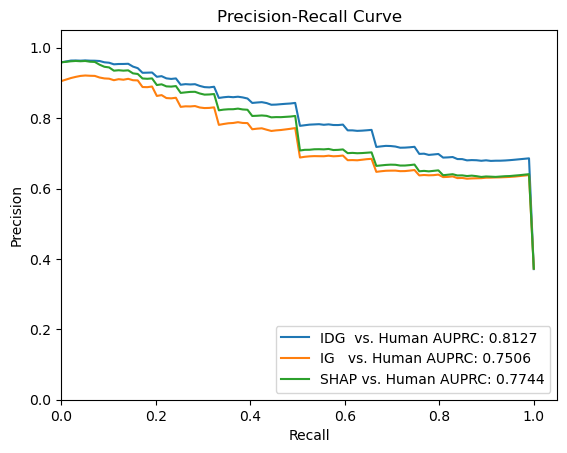

In [16]:
# Plot the results
plt.plot(
    recall_idg_human,
    precision_idg_human,
    label=f"IDG  vs. Human AUPRC: {auprc_idg_human:.4f}",
)

# plt.fill_between(
#     recall_idg_human,
#     precision_idg_human,
#     alpha=0.2,
#     label="IDG vs. Human AUPRC: {:.4f}".format(auprc_idg_human),
# )


plt.plot(
    recall_ig_human,
    precision_ig_human,
    label=f"IG   vs. Human AUPRC: {auprc_ig_human:.4f}",
)

# plt.fill_between(
#     recall_ig_human,
#     precision_ig_human,
#     alpha=0.2,
#     label="IG vs. Human AUPRC: {:.4f}".format(auprc_ig_human),
# )

plt.plot(
    recall_shap_human,
    precision_shap_human,
    label=f"SHAP vs. Human AUPRC: {auprc_shap_human:.4f}",
)

# plt.fill_between(
#     recall_shap_human,
#     precision_shap_human,
#     alpha=0.2,
#     label="SHAP vs. Human AUPRC: {:.4f}".format(auprc_shap_human),
# )


plt.xlabel("Recall")
plt.ylabel("Precision")

plt.xlim(0, 1.05)
plt.ylim(0, 1.05)

plt.title("Precision-Recall Curve")

plt.legend(loc="lower right")

plt.show()


## 8.2. Agreement with Model Behaviour (Faithfulness)

In [17]:
guids = df_test_trees["post_id"].to_list()


#### IDG

In [18]:
thresholds_idg = np.array([])
comprehensivenesses_idg = np.array([])
sufficiencies_idg = np.array([])

for guid in tqdma(guids):
    # Get the IDG explanation
    try:
        idg_expl = get_idg_explanations(IDG_DIR, df_test_trees, guid)
    except FileNotFoundError:
        print(f"File not found for post {guid}. Skipping...")
        continue
    except ValueError:
        print(f"Processing Error for post {guid}. Skipping...")
        continue

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    post = df_test_trees.filter(pl.col("post_id") == guid)
    tokens = post["tokens"].to_list()[0]

    model_clf.to(device)
    model_clf.eval()

    probabilities = predict_sample(
        model_clf,
        tokenizer,
        tokens,
        device,
        model_to_gpu_mode=False,
    )
    predicted_class = probabilities.argmax()

    comprehensivenesses_ = np.array([])
    sufficiencies_ = np.array([])
    thresholds_ = np.linspace(0, 1, 100)

    for threshold in thresholds_:
        comprehensiveness = compute_comprehensiveness(
            model_clf,
            tokenizer,
            tokens,
            idg_expl,
            threshold,
            device,
            original_probabilities=probabilities,
            predicted_class=predicted_class,
        )
        comprehensivenesses_ = np.append(
            comprehensivenesses_,
            comprehensiveness,
        )

        sufficiency = compute_sufficiency(
            model_clf,
            tokenizer,
            tokens,
            idg_expl,
            threshold,
            device,
            original_probabilities=probabilities,
            predicted_class=predicted_class,
        )
        sufficiencies_ = np.append(
            sufficiencies_,
            sufficiency,
        )

    comprehensivenesses_idg = np.vstack(
        (comprehensivenesses_idg, comprehensivenesses_),
    ) if comprehensivenesses_idg.size else comprehensivenesses_

    sufficiencies_idg = np.vstack(
        (sufficiencies_idg, sufficiencies_),
    ) if sufficiencies_idg.size else sufficiencies_

    thresholds_idg = np.vstack(
        (thresholds_idg, thresholds_),
    ) if thresholds_idg.size else thresholds_


  0%|          | 0/1376 [00:00<?, ?it/s]

File not found for post 10040607_gab. Skipping...
File not found for post 14445063_gab. Skipping...
File not found for post 1178921633031114752_twitter. Skipping...
File not found for post 1179048983420899328_twitter. Skipping...
File not found for post 1179098097160470529_twitter. Skipping...
File not found for post 1178785944238841857_twitter. Skipping...
File not found for post 12733084_gab. Skipping...
File not found for post 1178750958718914561_twitter. Skipping...
File not found for post 10362793_gab. Skipping...
File not found for post 10756657_gab. Skipping...
Processing Error for post 1079100239183675392_twitter. Skipping...
File not found for post 1109087701960146945_twitter. Skipping...
File not found for post 1163082929557450753_twitter. Skipping...
File not found for post 1171521116570959872_twitter. Skipping...
File not found for post 1258666596333170689_twitter. Skipping...
Processing Error for post 14971439_gab. Skipping...
File not found for post 21340695_gab. Skipping

#### IG

In [19]:
thresholds_ig = np.array([])
comprehensivenesses_ig = np.array([])
sufficiencies_ig = np.array([])

for guid in tqdma(guids):
    # Get the IDG explanation
    try:
        ig_expl = get_ig_explanations(IG_DIR, df_test_trees, guid)
    except FileNotFoundError:
        print(f"File not found for post {guid}. Skipping...")
        continue
    except ValueError:
        print(f"Processing Error for post {guid}. Skipping...")
        continue

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    post = df_test_trees.filter(pl.col("post_id") == guid)
    tokens = post["tokens"].to_list()[0]

    probabilities = predict_sample(
        model_clf,
        tokenizer,
        tokens,
        device,
    )
    predicted_class = probabilities.argmax()

    # Explanations were systematically computed for the hatespeech class.
    # If the predicted class is not hatespeech, we invert the explanation.
    if predicted_class != label2id["hatespeech"]:
        ig_expl = {k: -v for k, v in ig_expl.items()}


    comprehensivenesses_ = np.array([])
    sufficiencies_ = np.array([])
    thresholds_ = np.linspace(0, 1, 100)

    for threshold in thresholds_:
        comprehensiveness = compute_comprehensiveness(
            model_clf,
            tokenizer,
            tokens,
            ig_expl,
            threshold,
            device,
            original_probabilities=probabilities,
            predicted_class=predicted_class,
        )
        comprehensivenesses_ = np.append(
            comprehensivenesses_,
            comprehensiveness,
        )

        sufficiency = compute_sufficiency(
            model_clf,
            tokenizer,
            tokens,
            ig_expl,
            threshold,
            device,
            original_probabilities=probabilities,
            predicted_class=predicted_class,
        )
        sufficiencies_ = np.append(
            sufficiencies_,
            sufficiency,
        )

    comprehensivenesses_ig = np.vstack(
        (comprehensivenesses_ig, comprehensivenesses_),
    ) if comprehensivenesses_ig.size else comprehensivenesses_

    sufficiencies_ig = np.vstack(
        (sufficiencies_ig, sufficiencies_),
    ) if sufficiencies_ig.size else sufficiencies_

    thresholds_ig = np.vstack(
        (thresholds_ig, thresholds_),
    ) if thresholds_ig.size else thresholds_


  0%|          | 0/1376 [00:00<?, ?it/s]

Processing Error for post 1178251992801533952_twitter. Skipping...
Processing Error for post 23377953_gab. Skipping...
Processing Error for post 10177273_gab. Skipping...
Processing Error for post 22393483_gab. Skipping...
Processing Error for post 1177988237765287936_twitter. Skipping...
Processing Error for post 1178976586168754177_twitter. Skipping...
Processing Error for post 12029101_gab. Skipping...
Processing Error for post 21446735_gab. Skipping...
Processing Error for post 10040607_gab. Skipping...
Processing Error for post 1178866509139103744_twitter. Skipping...
Processing Error for post 15319506_gab. Skipping...
Processing Error for post 26732378_gab. Skipping...
Processing Error for post 22425202_gab. Skipping...
Processing Error for post 17501192_gab. Skipping...
Processing Error for post 14445063_gab. Skipping...
Processing Error for post 26551816_gab. Skipping...
Processing Error for post 20728328_gab. Skipping...
Processing Error for post 13071649_gab. Skipping...
Proc

#### SHAP

In [20]:
thresholds_shap = np.array([])
comprehensivenesses_shap = np.array([])
sufficiencies_shap = np.array([])

for guid in tqdma(guids):
    # Get the IDG explanation
    try:
        shap_expl = get_shap_explanations(SHAP_DIR, df_test_trees, guid)
    except FileNotFoundError:
        print(f"File not found for post {guid}. Skipping...")
        continue
    except ValueError:
        print(f"Processing Error for post {guid}. Skipping...")
        continue

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    post = df_test_trees.filter(pl.col("post_id") == guid)
    tokens = post["tokens"].to_list()[0]

    probabilities = predict_sample(
        model_clf,
        tokenizer,
        tokens,
        device,
    )
    predicted_class = probabilities.argmax()

    # Explanations were systematically computed for the hatespeech class.
    # If the predicted class is not hatespeech, we invert the explanation.
    if predicted_class != label2id["hatespeech"]:
        ig_expl = {k: -v for k, v in ig_expl.items()}

    comprehensivenesses_ = np.array([])
    sufficiencies_ = np.array([])
    thresholds_ = np.linspace(0, 1, 100)

    for threshold in thresholds_:
        comprehensiveness = compute_comprehensiveness(
            model_clf,
            tokenizer,
            tokens,
            shap_expl,
            threshold,
            device,
            original_probabilities=probabilities,
            predicted_class=predicted_class,
        )
        comprehensivenesses_ = np.append(
            comprehensivenesses_,
            comprehensiveness,
        )

        sufficiency = compute_sufficiency(
            model_clf,
            tokenizer,
            tokens,
            shap_expl,
            threshold,
            device,
            original_probabilities=probabilities,
            predicted_class=predicted_class,
        )
        sufficiencies_ = np.append(
            sufficiencies_,
            sufficiency,
        )

    comprehensivenesses_shap = np.vstack(
        (comprehensivenesses_shap, comprehensivenesses_),
    ) if comprehensivenesses_shap.size else comprehensivenesses_

    sufficiencies_shap = np.vstack(
        (sufficiencies_shap, sufficiencies_),
    ) if sufficiencies_shap.size else sufficiencies_

    thresholds_shap = np.vstack(
        (thresholds_shap, thresholds_),
    ) if thresholds_shap.size else thresholds_


  0%|          | 0/1376 [00:00<?, ?it/s]

Processing Error for post 1178251992801533952_twitter. Skipping...
Processing Error for post 23377953_gab. Skipping...
Processing Error for post 10177273_gab. Skipping...
Processing Error for post 22393483_gab. Skipping...
Processing Error for post 1177988237765287936_twitter. Skipping...
Processing Error for post 1178976586168754177_twitter. Skipping...
Processing Error for post 12029101_gab. Skipping...
Processing Error for post 21446735_gab. Skipping...
Processing Error for post 10040607_gab. Skipping...
Processing Error for post 1178866509139103744_twitter. Skipping...
Processing Error for post 15319506_gab. Skipping...
Processing Error for post 26732378_gab. Skipping...
Processing Error for post 22425202_gab. Skipping...
Processing Error for post 17501192_gab. Skipping...
Processing Error for post 14445063_gab. Skipping...
Processing Error for post 26551816_gab. Skipping...
Processing Error for post 20728328_gab. Skipping...
Processing Error for post 13071649_gab. Skipping...
Proc

#### Results

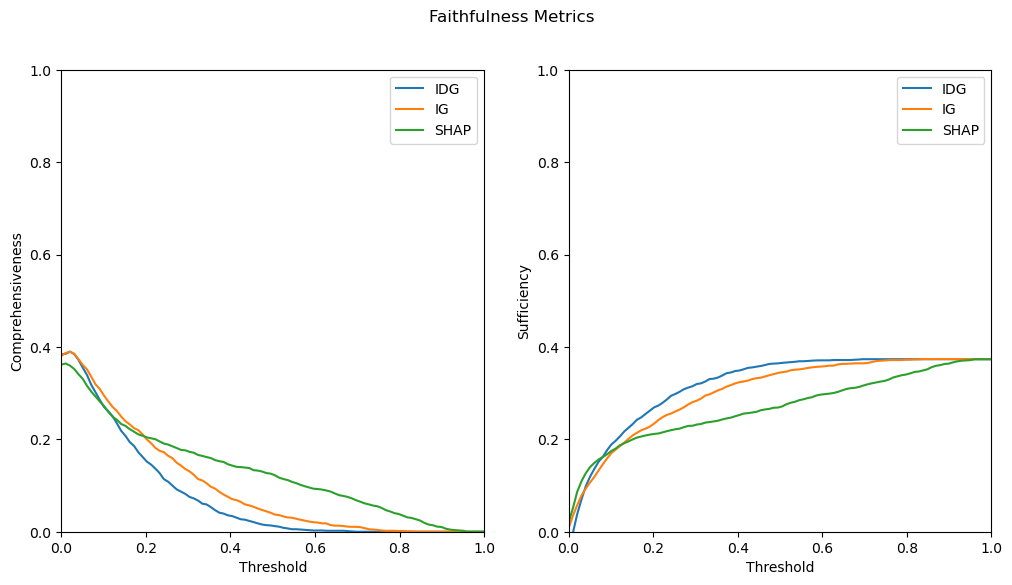

In [22]:
# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(
    np.mean(thresholds_idg, axis=0),
    np.mean(comprehensivenesses_idg, axis=0),
    label="IDG",
)
ax[0].plot(
    np.mean(thresholds_ig, axis=0),
    np.mean(comprehensivenesses_ig, axis=0),
    label="IG",
)
ax[0].plot(
    np.mean(thresholds_shap, axis=0),
    np.mean(comprehensivenesses_shap, axis=0),
    label="SHAP",
)
ax[0].set_xlabel("Threshold")
ax[0].set_ylabel("Comprehensiveness")

ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)

ax[0].legend()

ax[1].plot(
    np.mean(thresholds_idg, axis=0),
    np.mean(sufficiencies_idg, axis=0),
    label="IDG",
)
ax[1].plot(
    np.mean(thresholds_ig, axis=0),
    np.mean(sufficiencies_ig, axis=0),
    label="IG",
)
ax[1].plot(
    np.mean(thresholds_shap, axis=0),
    np.mean(sufficiencies_shap, axis=0),
    label="SHAP",
)
ax[1].set_xlabel("Threshold")
ax[1].set_ylabel("Sufficiency")

ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)

ax[1].legend()

plt.suptitle("Faithfulness Metrics")
plt.show()


In [23]:
# Save the results to a pickle file
with Path.open(EVALUATION_DIR / "attr_evaluation_results.pkl", "wb") as f:
    pickle.dump(
        {
            "agreements_at_k_idg_human": agreements_at_k_idg_human,
            "agreements_at_k_ig_human": agreements_at_k_ig_human,
            "agreements_at_k_shap_human": agreements_at_k_shap_human,

            "mean_agreements_at_k_idg_human": mean_agreements_at_k_idg_human,
            "mean_agreements_at_k_ig_human": mean_agreements_at_k_ig_human,
            "mean_agreements_at_k_shap_human": mean_agreements_at_k_shap_human,

            "precisions_idg_human": precisions_idg_human,
            "recalls_idg_human": recalls_idg_human,
            "auprcs_idg_human": auprcs_idg_human,

            "precision_idg_human": precision_idg_human,
            "recall_idg_human": recall_idg_human,
            "auprc_idg_human": auprc_idg_human,

            "precisions_ig_human": precisions_ig_human,
            "recalls_ig_human": recalls_ig_human,
            "auprcs_ig_human": auprcs_ig_human,

            "precision_ig_human": precision_ig_human,
            "recall_ig_human": recall_ig_human,
            "auprc_ig_human": auprc_ig_human,

            "precisions_shap_human": precisions_shap_human,
            "recalls_shap_human": recalls_shap_human,
            "auprcs_shap_human": auprcs_shap_human,

            "precision_shap_human": precision_shap_human,
            "recall_shap_human": recall_shap_human,
            "auprc_shap_human": auprc_shap_human,

            "thresholds_idg": thresholds_idg,
            "comprehensivenesses_idg": comprehensivenesses_idg,
            "sufficiencies_idg": sufficiencies_idg,

            "thresholds_ig": thresholds_ig,
            "comprehensivenesses_ig": comprehensivenesses_ig,
            "sufficiencies_ig": sufficiencies_ig,

            "thresholds_shap": thresholds_shap,
            "comprehensivenesses_shap": comprehensivenesses_shap,
            "sufficiencies_shap": sufficiencies_shap,
        },
        f,
    )


***

In [24]:
with Path.open(EVALUATION_DIR / "attr_evaluation_results.pkl", "rb") as f:
    results = pickle.load(f)

agreements_at_k_idg_human = results["agreements_at_k_idg_human"]
agreements_at_k_ig_human = results["agreements_at_k_ig_human"]
agreements_at_k_shap_human = results["agreements_at_k_shap_human"]

mean_agreements_at_k_idg_human = results["mean_agreements_at_k_idg_human"]
mean_agreements_at_k_ig_human = results["mean_agreements_at_k_ig_human"]
mean_agreements_at_k_shap_human = results["mean_agreements_at_k_shap_human"]

precisions_idg_human = results["precisions_idg_human"]
recalls_idg_human = results["recalls_idg_human"]
auprcs_idg_human = results["auprcs_idg_human"]

precision_idg_human = results["precision_idg_human"]
recall_idg_human = results["recall_idg_human"]
auprc_idg_human = results["auprc_idg_human"]

precisions_ig_human = results["precisions_ig_human"]
recalls_ig_human = results["recalls_ig_human"]
auprcs_ig_human = results["auprcs_ig_human"]

precision_ig_human = results["precision_ig_human"]
recall_ig_human = results["recall_ig_human"]
auprc_ig_human = results["auprc_ig_human"]

precisions_shap_human = results["precisions_shap_human"]
recalls_shap_human = results["recalls_shap_human"]
auprcs_shap_human = results["auprcs_shap_human"]

precision_shap_human = results["precision_shap_human"]
recall_shap_human = results["recall_shap_human"]
auprc_shap_human = results["auprc_shap_human"]

thresholds_idg = results["thresholds_idg"]
comprehensivenesses_idg = results["comprehensivenesses_idg"]
sufficiencies_idg = results["sufficiencies_idg"]

thresholds_ig = results["thresholds_ig"]
comprehensivenesses_ig = results["comprehensivenesses_ig"]
sufficiencies_ig = results["sufficiencies_ig"]

thresholds_shap = results["thresholds_shap"]
comprehensivenesses_shap = results["comprehensivenesses_shap"]
sufficiencies_shap = results["sufficiencies_shap"]



In [ ]:
colors = {
    "IDG": "#FFBF00",
    "IG": "#E83F6F",
    "SHAP": "#5A9367",
}


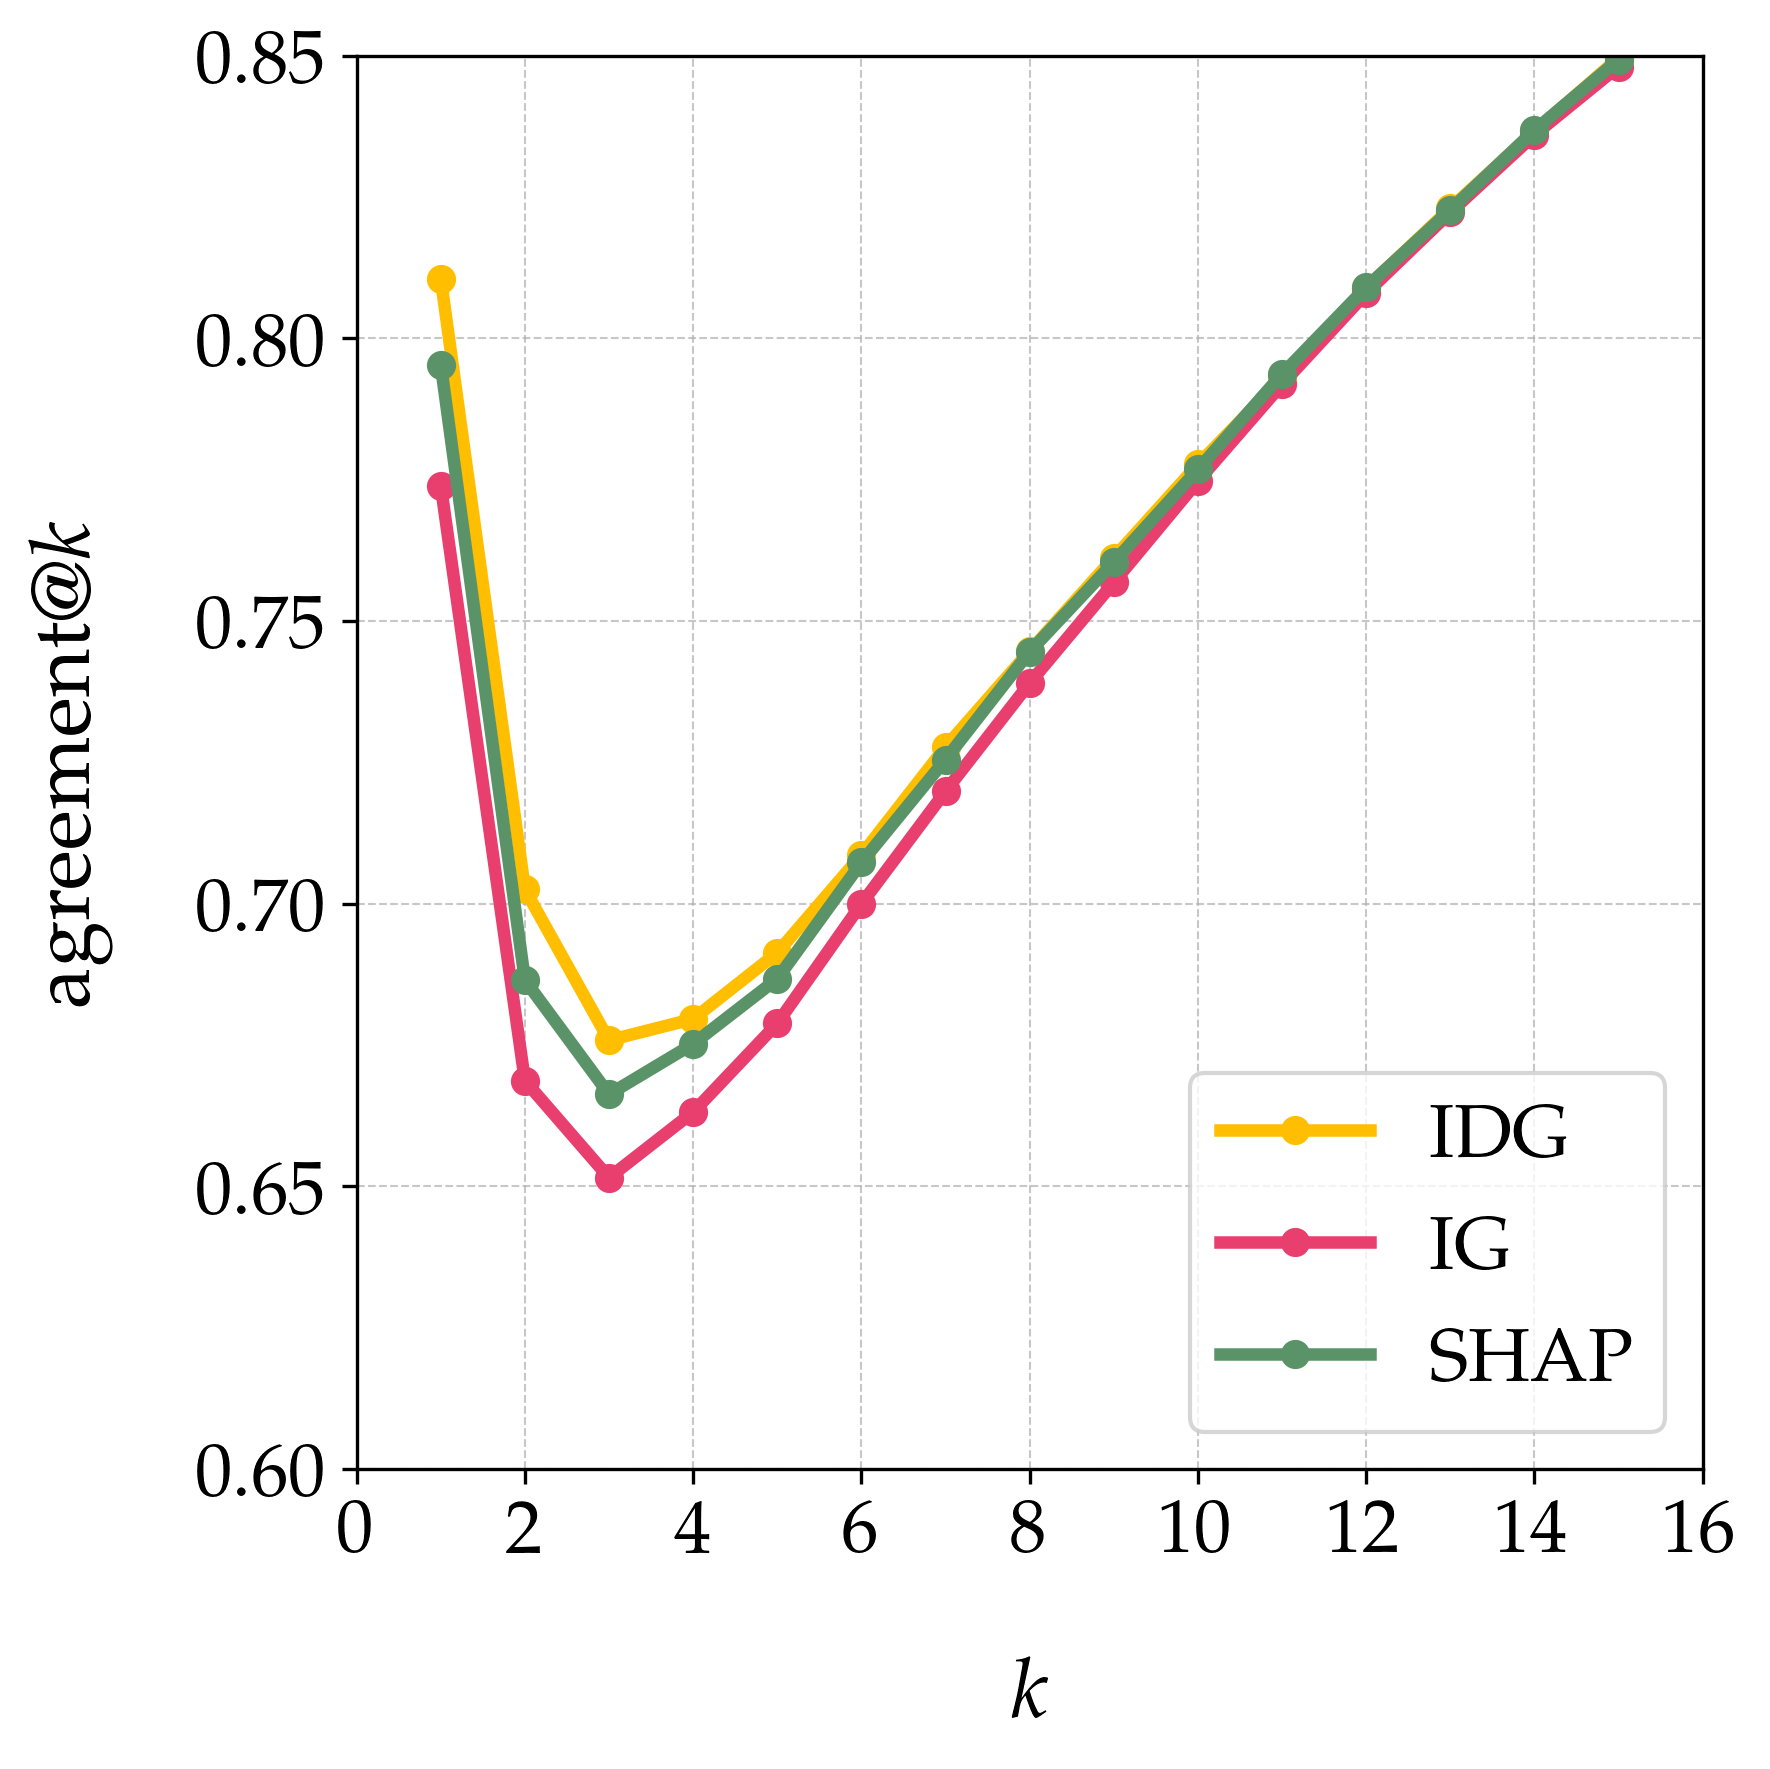

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

ax.plot(
    mean_agreements_at_k_idg_human.keys(),
    mean_agreements_at_k_idg_human.values(),
    marker="o",
    color=colors["IDG"],
    lw=3,
    label="IDG",
)
ax.plot(
    mean_agreements_at_k_ig_human.keys(),
    mean_agreements_at_k_ig_human.values(),
    marker="o",
    color=colors["IG"],
    lw=3,
    label="IG",
)
ax.plot(
    mean_agreements_at_k_shap_human.keys(),
    mean_agreements_at_k_shap_human.values(),
    marker="o",
    color=colors["SHAP"],
    lw=3,
    label="SHAP",
)

ax.legend(fontsize=18)

ax.tick_params(axis="both", which="major", labelsize=18)

ax.set_xlabel(r"$k$", fontdict={"size": 20}, labelpad=20)
ax.set_ylabel(r"agreement@$k$", fontdict={"size": 20}, labelpad=20)

ax.set_xlim(0, 16)
ax.set_xticks(np.arange(0, 17, 2))

ax.set_ylim(0.6, 0.85)

ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

ax.set_aspect('auto', adjustable='box')

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "expl_eval" / "eval_mean_agreements_at_k_human.png",
    bbox_inches="tight",
)


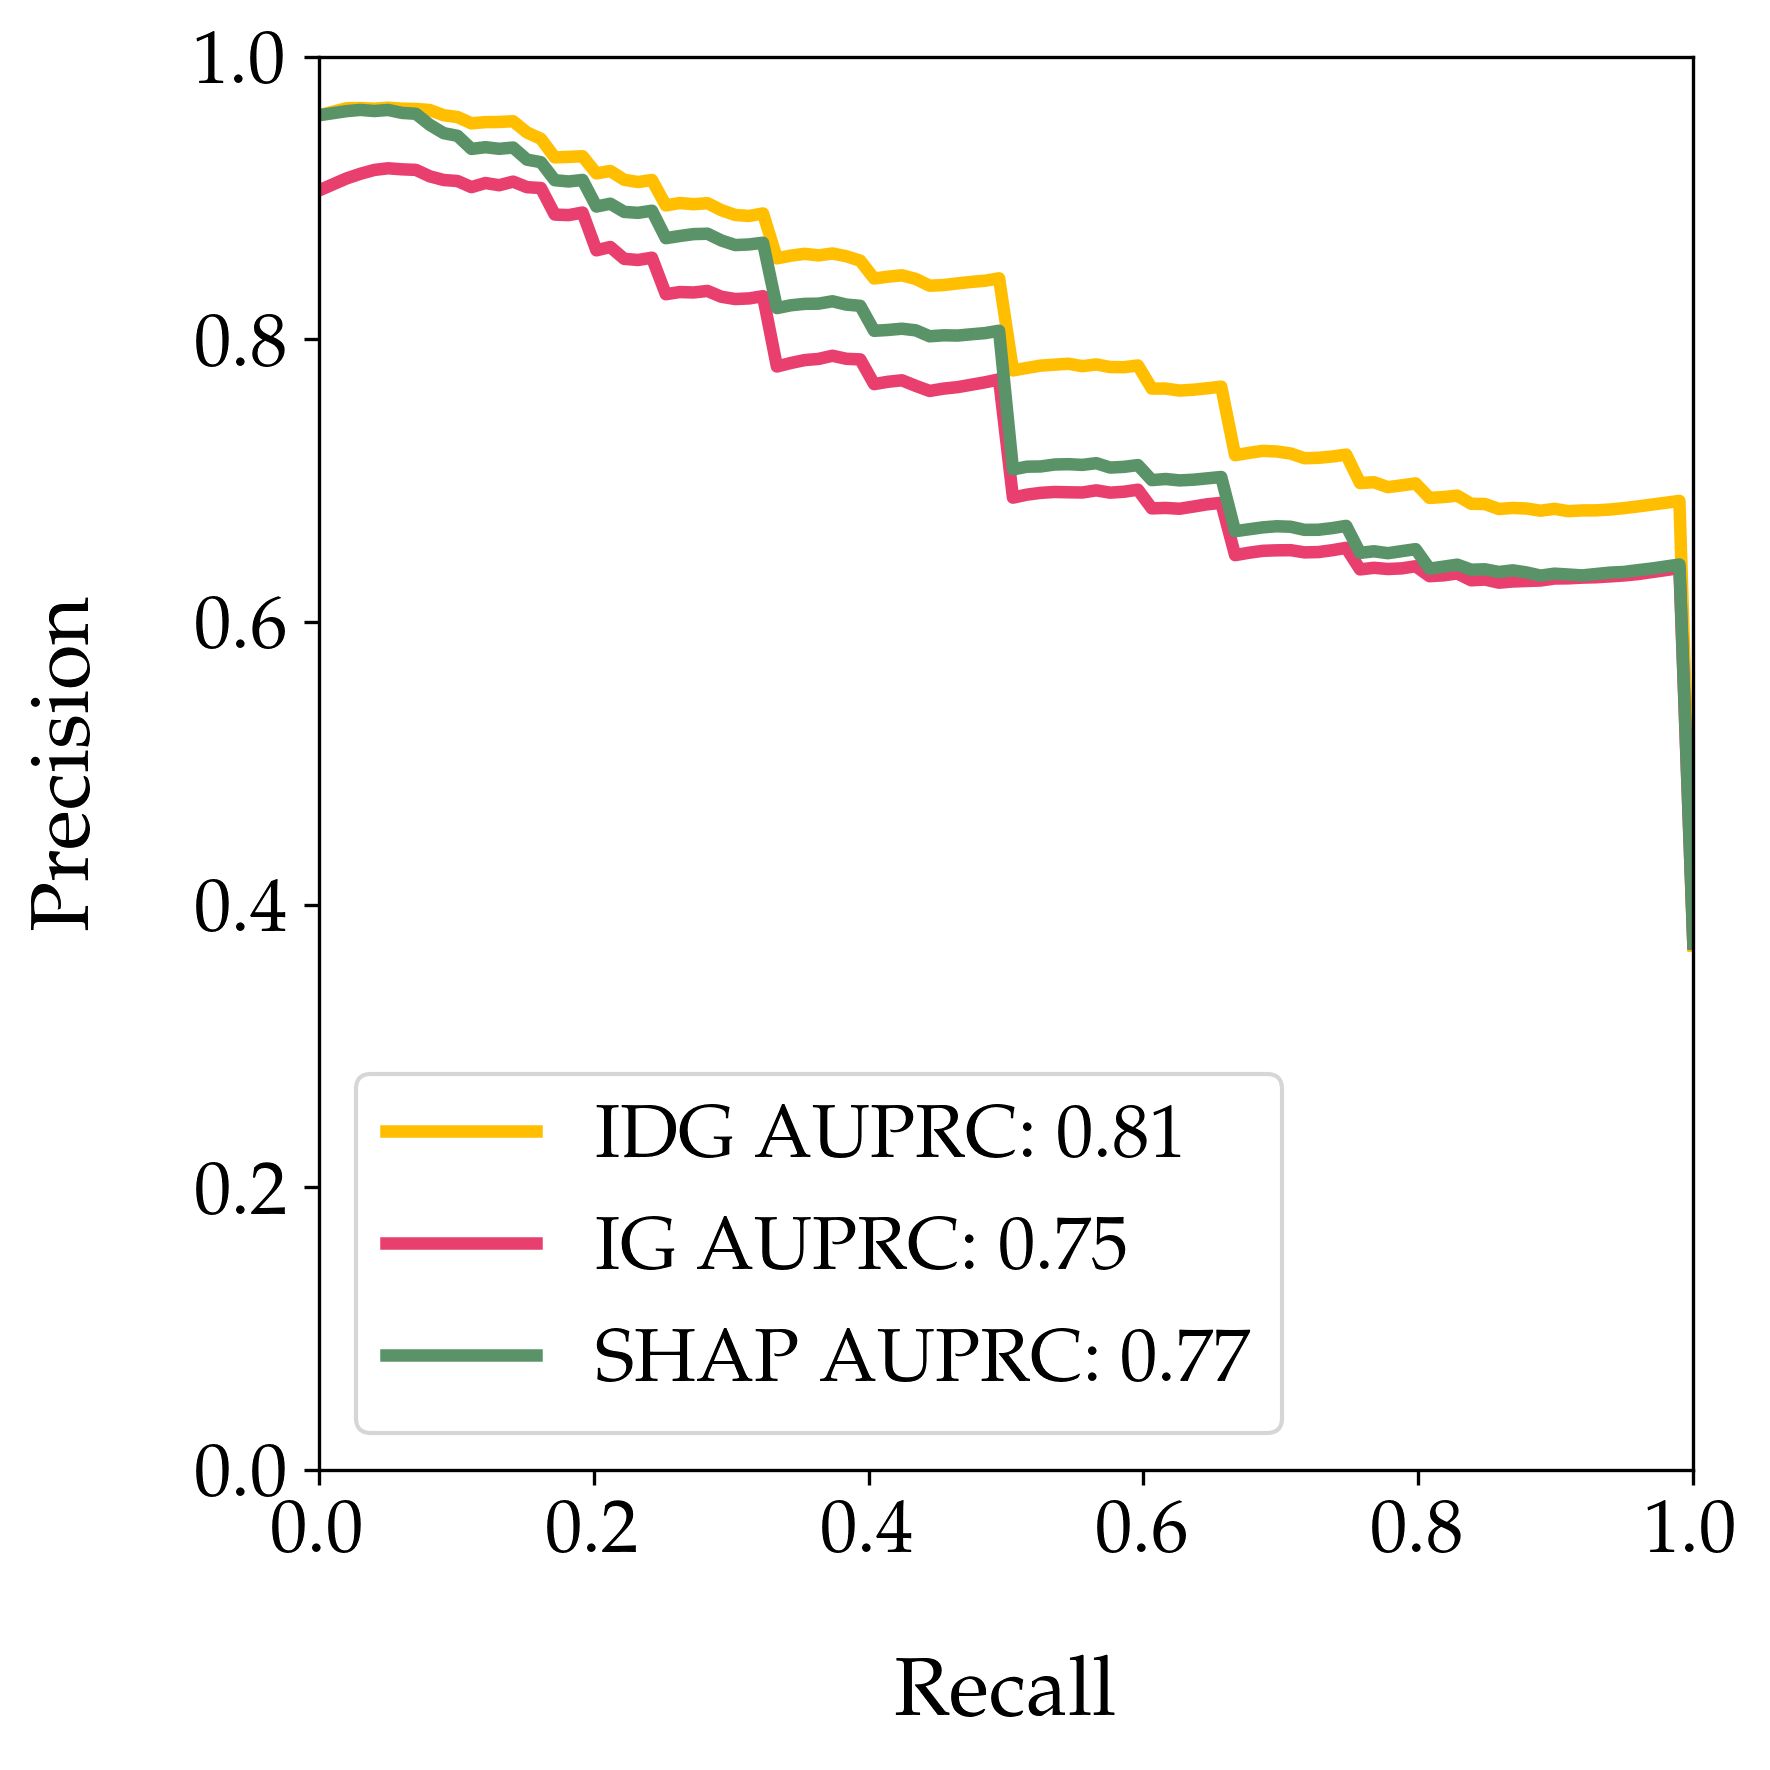

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)


ax.plot(
    recall_idg_human,
    precision_idg_human,
    label=f"IDG AUPRC: {auprc_idg_human:.2f}",
    color=colors["IDG"],
    lw=3,
)
ax.plot(
    recall_ig_human,
    precision_ig_human,
    label=f"IG AUPRC: {auprc_ig_human:.2f}",
    color=colors["IG"],
    lw=3,
)
ax.plot(
    recall_shap_human,
    precision_shap_human,
    label=f"SHAP AUPRC: {auprc_shap_human:.2f}",
    color=colors["SHAP"],
    lw=3,
)

ax.legend(fontsize=18)

ax.tick_params(axis="both", which="major", labelsize=18)

ax.set_xlabel(r"Recall", fontdict={"size": 20}, labelpad=20)
ax.set_ylabel(r"Precision", fontdict={"size": 20}, labelpad=20)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "expl_eval"  / "eval_mean_prcurve_human.png",
    bbox_inches="tight",
)



/tmp/ipykernel_51909/3485428389.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


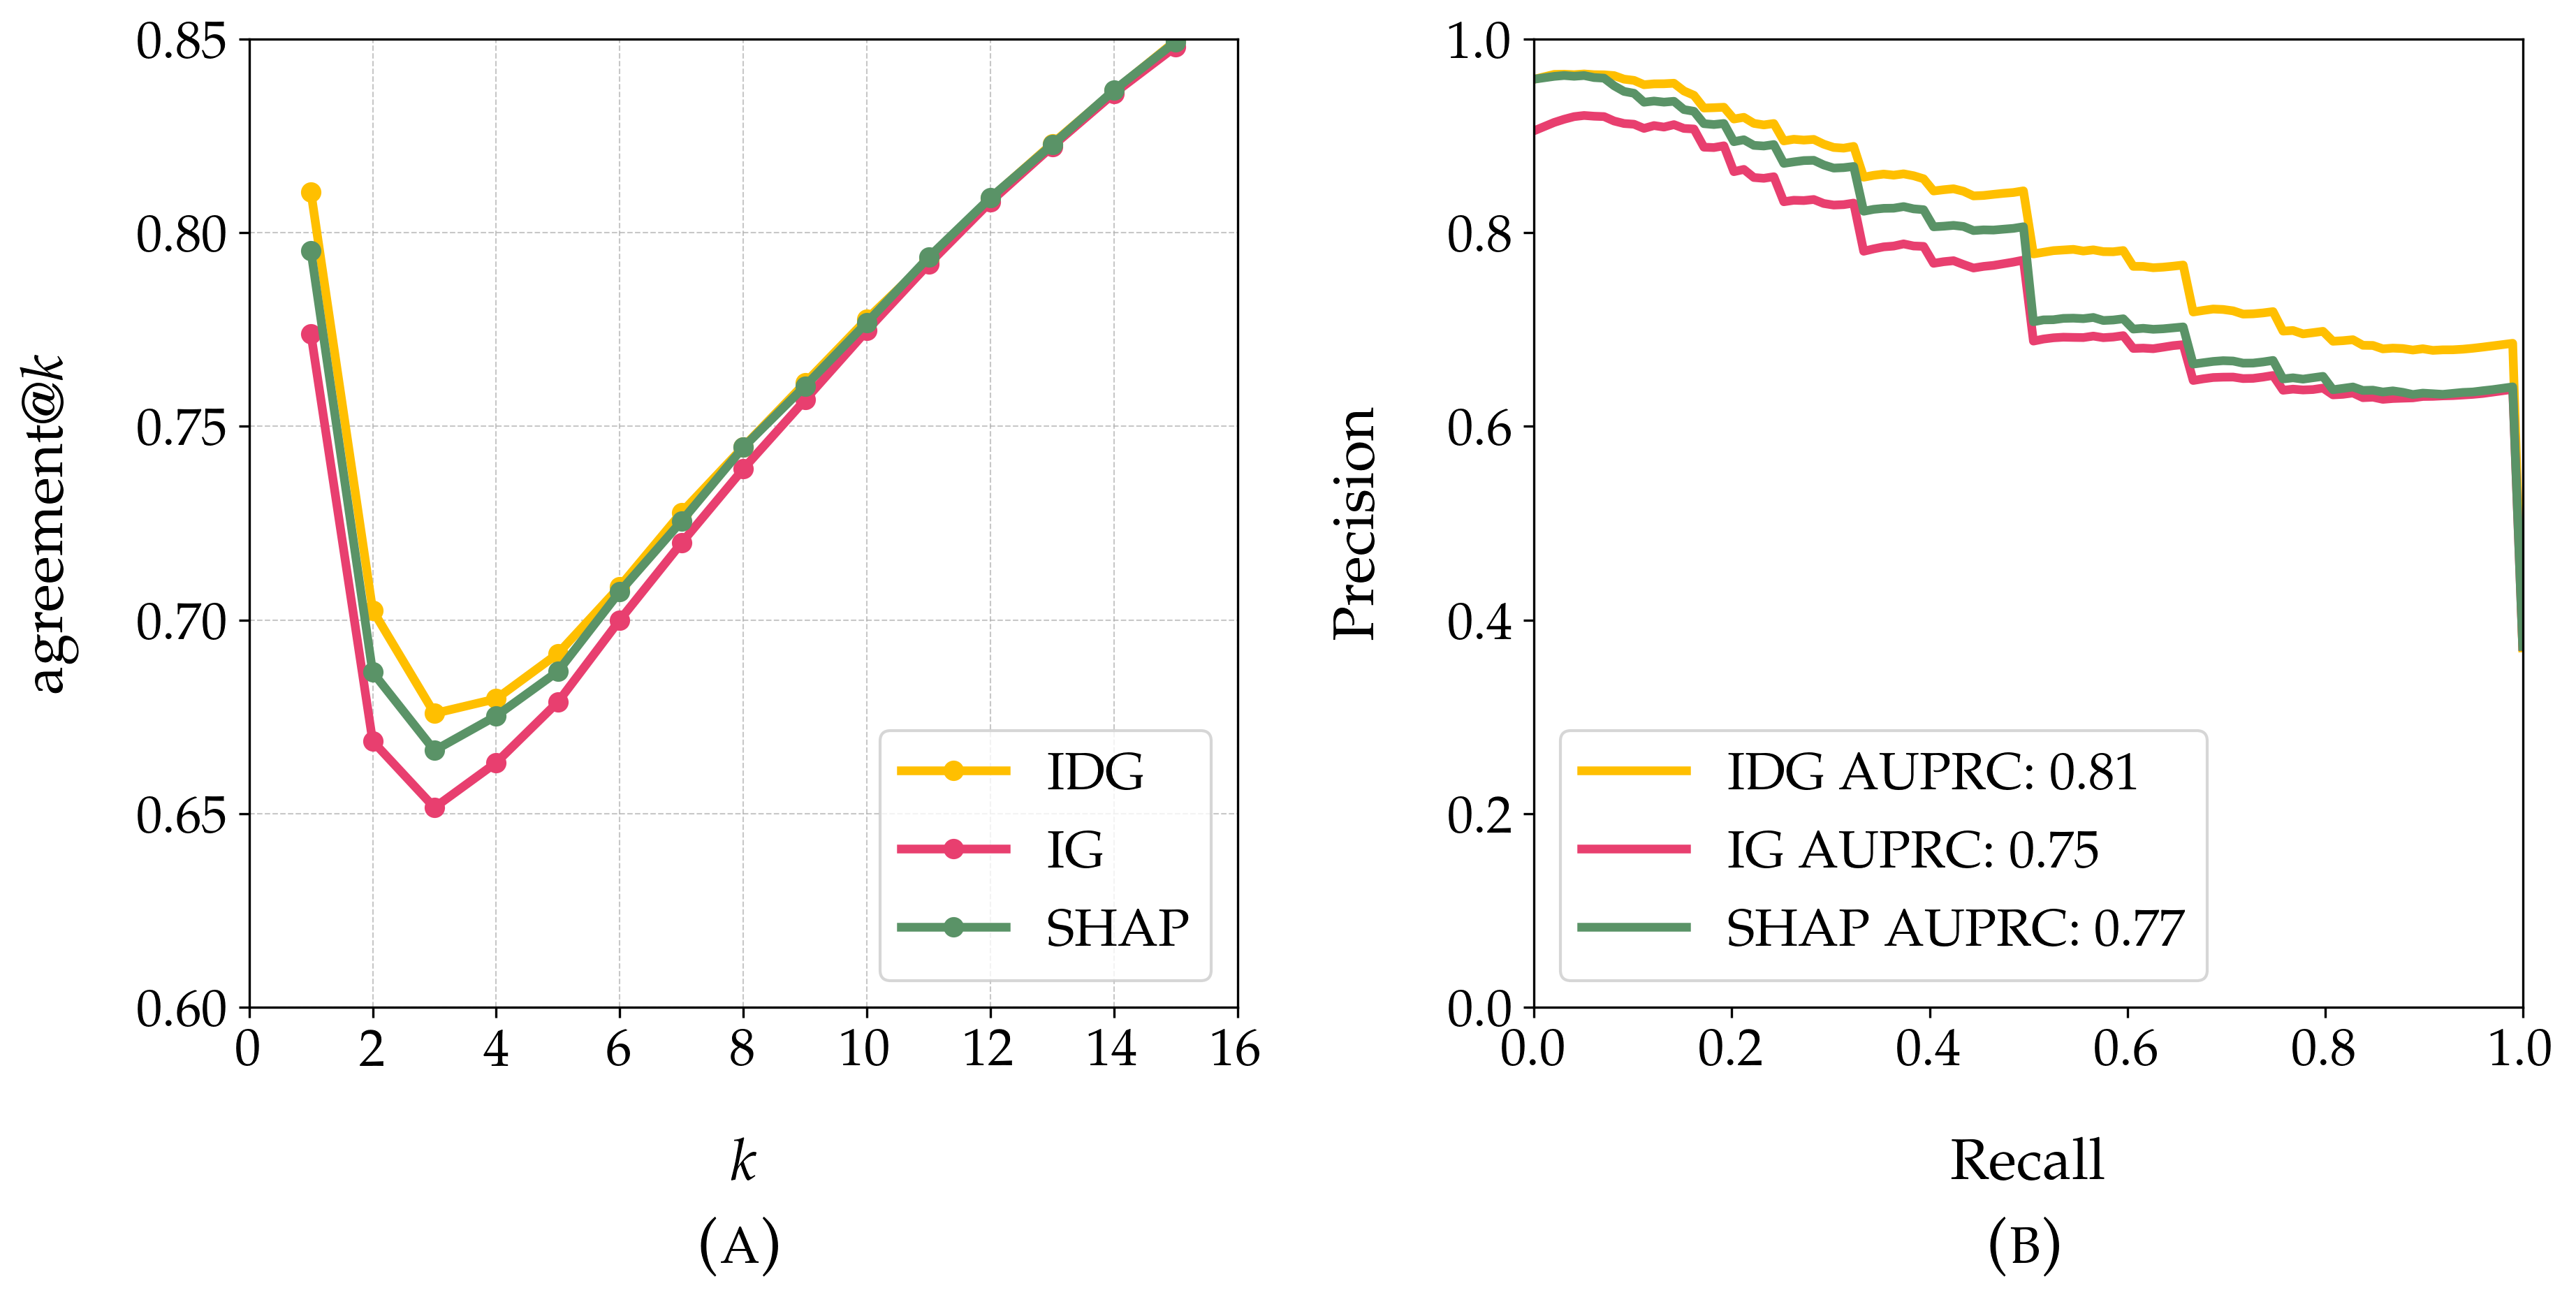

In [ ]:
fig, axs = plt.subplots(
    1, 2,
    figsize=(14, 6),
    dpi=300,
    gridspec_kw={"wspace": 0.3},
)


axs[0].plot(
    mean_agreements_at_k_idg_human.keys(),
    mean_agreements_at_k_idg_human.values(),
    marker="o",
    color=colors["IDG"],
    lw=3,
    label="IDG",
)
axs[0].plot(
    mean_agreements_at_k_ig_human.keys(),
    mean_agreements_at_k_ig_human.values(),
    marker="o",
    color=colors["IG"],
    lw=3,
    label="IG",
)
axs[0].plot(
    mean_agreements_at_k_shap_human.keys(),
    mean_agreements_at_k_shap_human.values(),
    marker="o",
    color=colors["SHAP"],
    lw=3,
    label="SHAP",
)

axs[0].legend(fontsize=18)

axs[0].tick_params(axis="both", which="major", labelsize=18)

axs[0].set_xlabel(r"$k$", fontdict={"size": 20}, labelpad=20)
axs[0].set_ylabel(r"agreement@$k$", fontdict={"size": 20}, labelpad=20)

axs[0].set_xlim(0, 16)
axs[0].set_xticks(np.arange(0, 17, 2))

axs[0].set_ylim(0.6, 0.85)

axs[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)


axs[1].plot(
    recall_idg_human,
    precision_idg_human,
    label=f"IDG AUPRC: {auprc_idg_human:.2f}",
    color=colors["IDG"],
    lw=3,
)
axs[1].plot(
    recall_ig_human,
    precision_ig_human,
    label=f"IG AUPRC: {auprc_ig_human:.2f}",
    color=colors["IG"],
    lw=3,
)
axs[1].plot(
    recall_shap_human,
    precision_shap_human,
    label=f"SHAP AUPRC: {auprc_shap_human:.2f}",
    color=colors["SHAP"],
    lw=3,
)

axs[1].legend(fontsize=18)

axs[1].tick_params(axis="both", which="major", labelsize=18)

axs[1].set_xlabel(r"Recall", fontdict={"size": 20}, labelpad=20)
axs[1].set_ylabel(r"Precision", fontdict={"size": 20}, labelpad=20)

axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)

axs[0].text(0.5, -.25, r"(\textsc{a})", transform=axs[0].transAxes,
            ha="center", va="center", fontsize=22)
axs[1].text(0.5, -.25, r"(\textsc{b})", transform=axs[1].transAxes,
            ha="center", va="center", fontsize=22)

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "expl_eval" / "eval_plausibility_comb.png",
    bbox_inches="tight",
)


In [ ]:
from sklearn.metrics import auc

aucpc_idg = auc(
    np.mean(thresholds_idg, axis=0),
    np.mean(comprehensivenesses_idg, axis=0),
)

aucpc_ig = auc(
    np.mean(thresholds_ig, axis=0),
    np.mean(comprehensivenesses_ig, axis=0),
)

aucpc_shap = auc(
    np.mean(thresholds_shap, axis=0),
    np.mean(comprehensivenesses_shap, axis=0),
)

# Compute area over the perturbation curve - sufficiency
aospc_idg = 1. - auc(
    np.mean(thresholds_idg, axis=0),
    np.mean(sufficiencies_idg, axis=0),
)
aospc_ig = 1. - auc(
    np.mean(thresholds_ig, axis=0),
    np.mean(sufficiencies_ig, axis=0),
)
aospc_shap = 1. - auc(
    np.mean(thresholds_shap, axis=0),
    np.mean(sufficiencies_shap, axis=0),
)


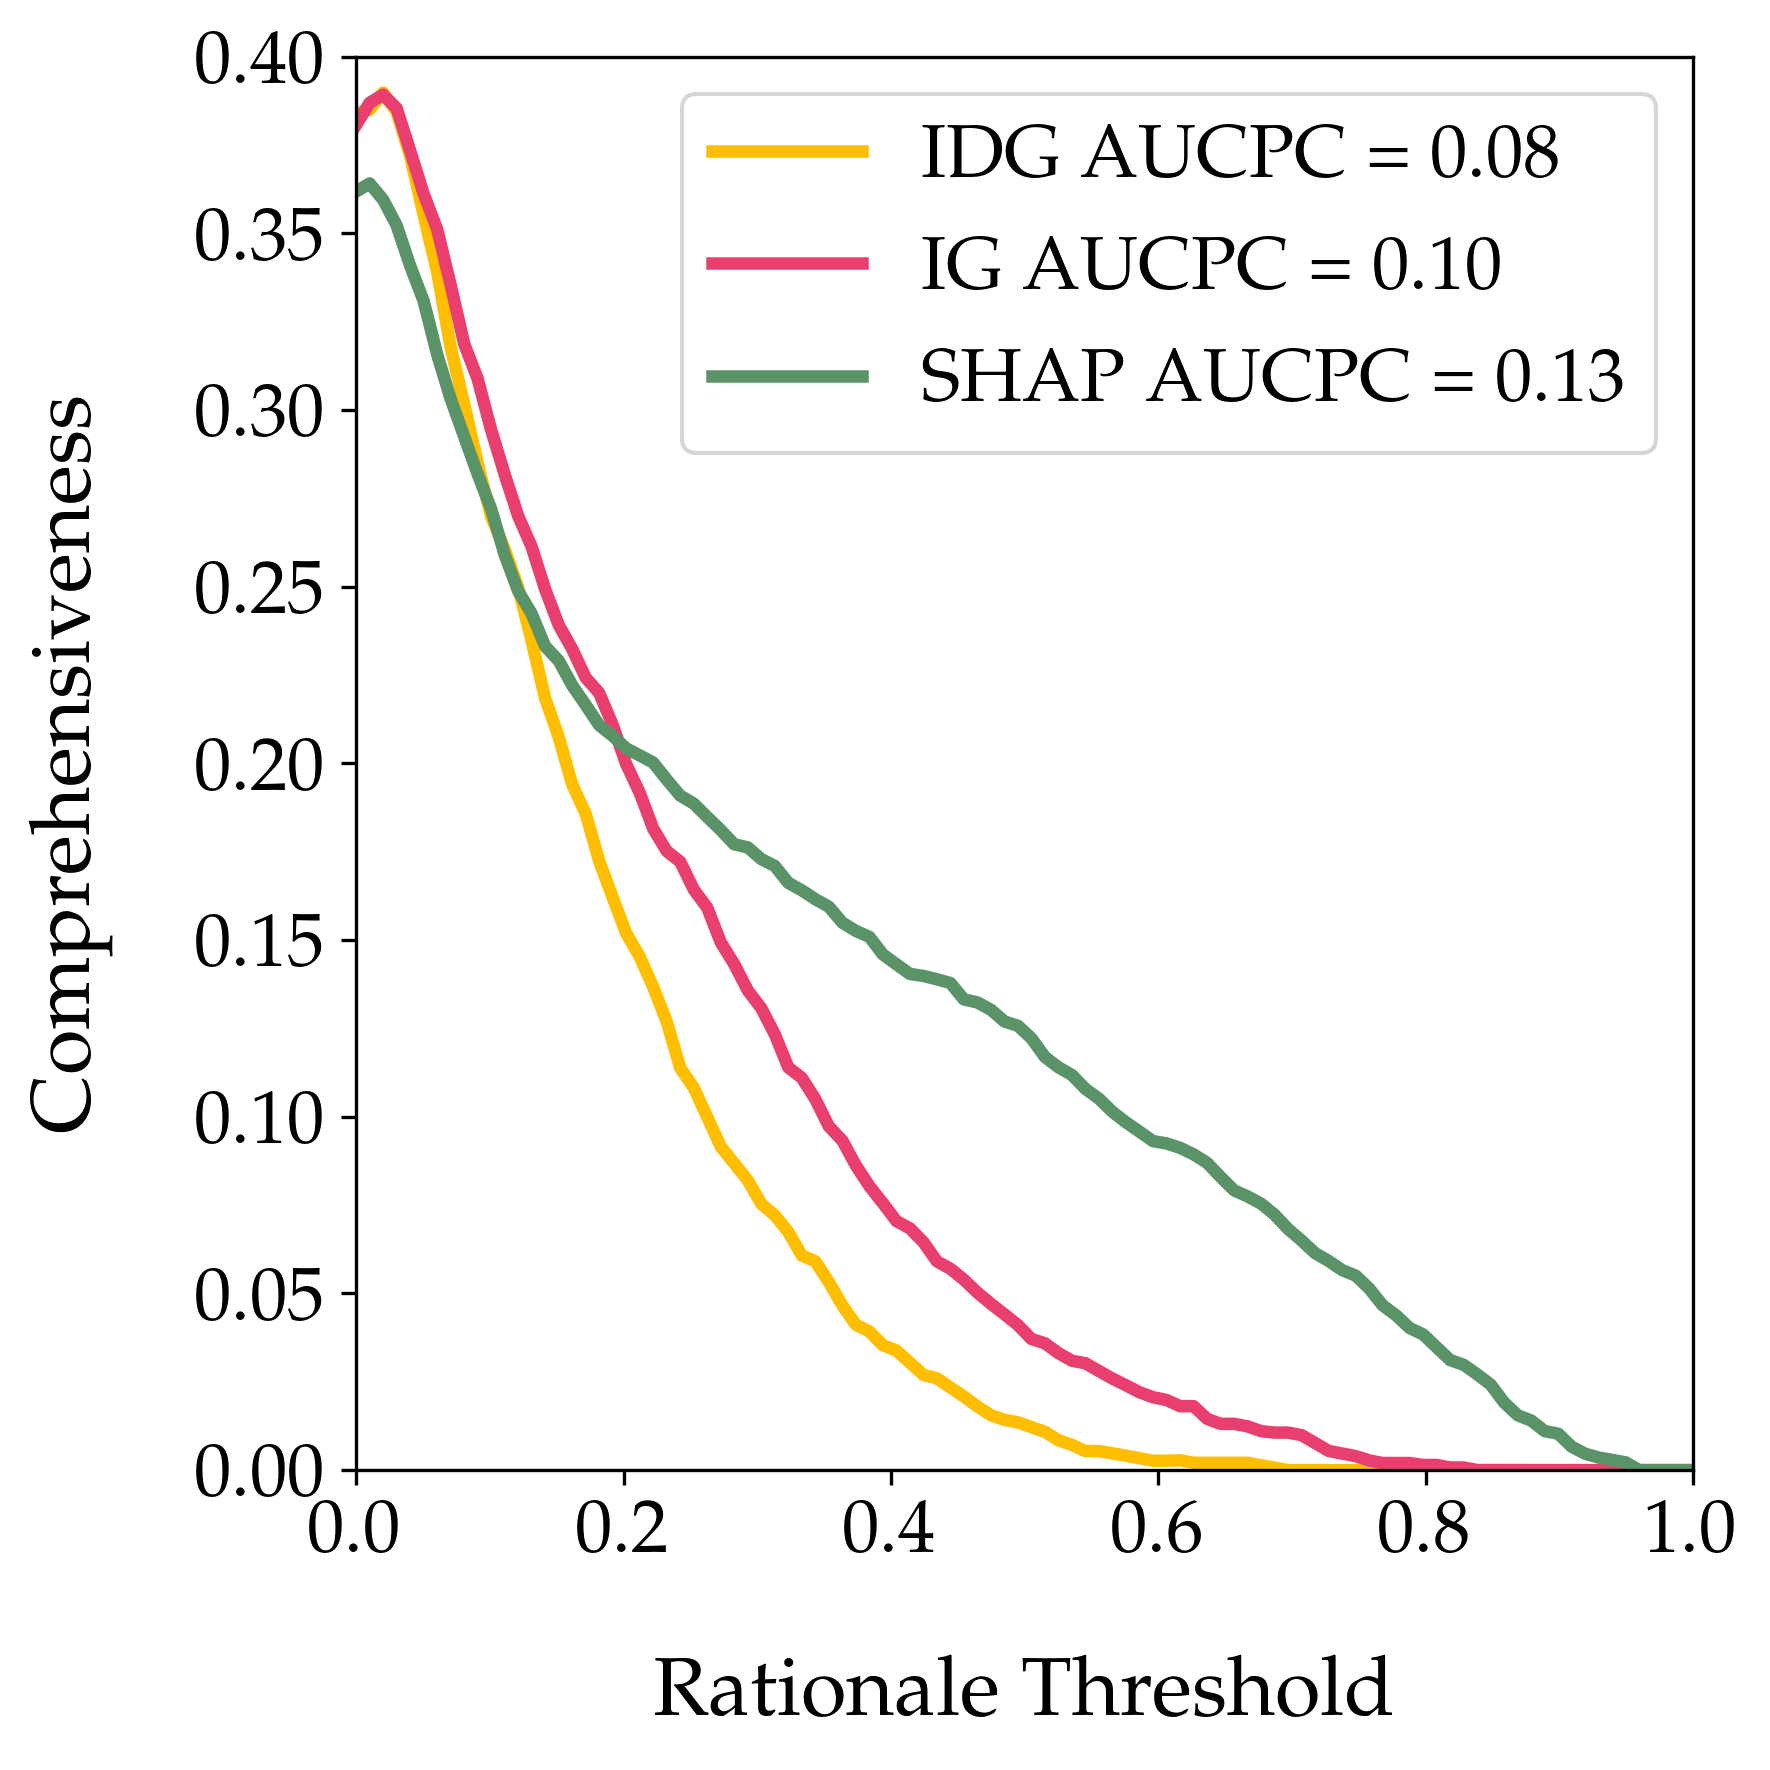

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

ax.plot(
    np.mean(thresholds_idg, axis=0),
    np.mean(comprehensivenesses_idg, axis=0),
    label=f"IDG AUCPC = {aucpc_idg:.2f}",
    color=colors["IDG"],
    lw=3,
)
ax.plot(
    np.mean(thresholds_ig, axis=0),
    np.mean(comprehensivenesses_ig, axis=0),
    label=f"IG AUCPC = {aucpc_ig:.2f}",
    color=colors["IG"],
    lw=3,
)
ax.plot(
    np.mean(thresholds_shap, axis=0),
    np.mean(comprehensivenesses_shap, axis=0),
    label=f"SHAP AUCPC = {aucpc_shap:.2f}",
    color=colors["SHAP"],
    lw=3,
)

ax.legend(fontsize=18)

ax.tick_params(axis="both", which="major", labelsize=18)

ax.set_xlabel(r"Rationale Threshold", fontdict={"size": 20}, labelpad=20)
ax.set_ylabel(r"Comprehensiveness", fontdict={"size": 20}, labelpad=20)

ax.set_xlim(0, 1)
ax.set_ylim(0, 0.40)


plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "expl_eval" / "eval_comprehensiveness_1st_order.png",
    bbox_inches="tight",
)


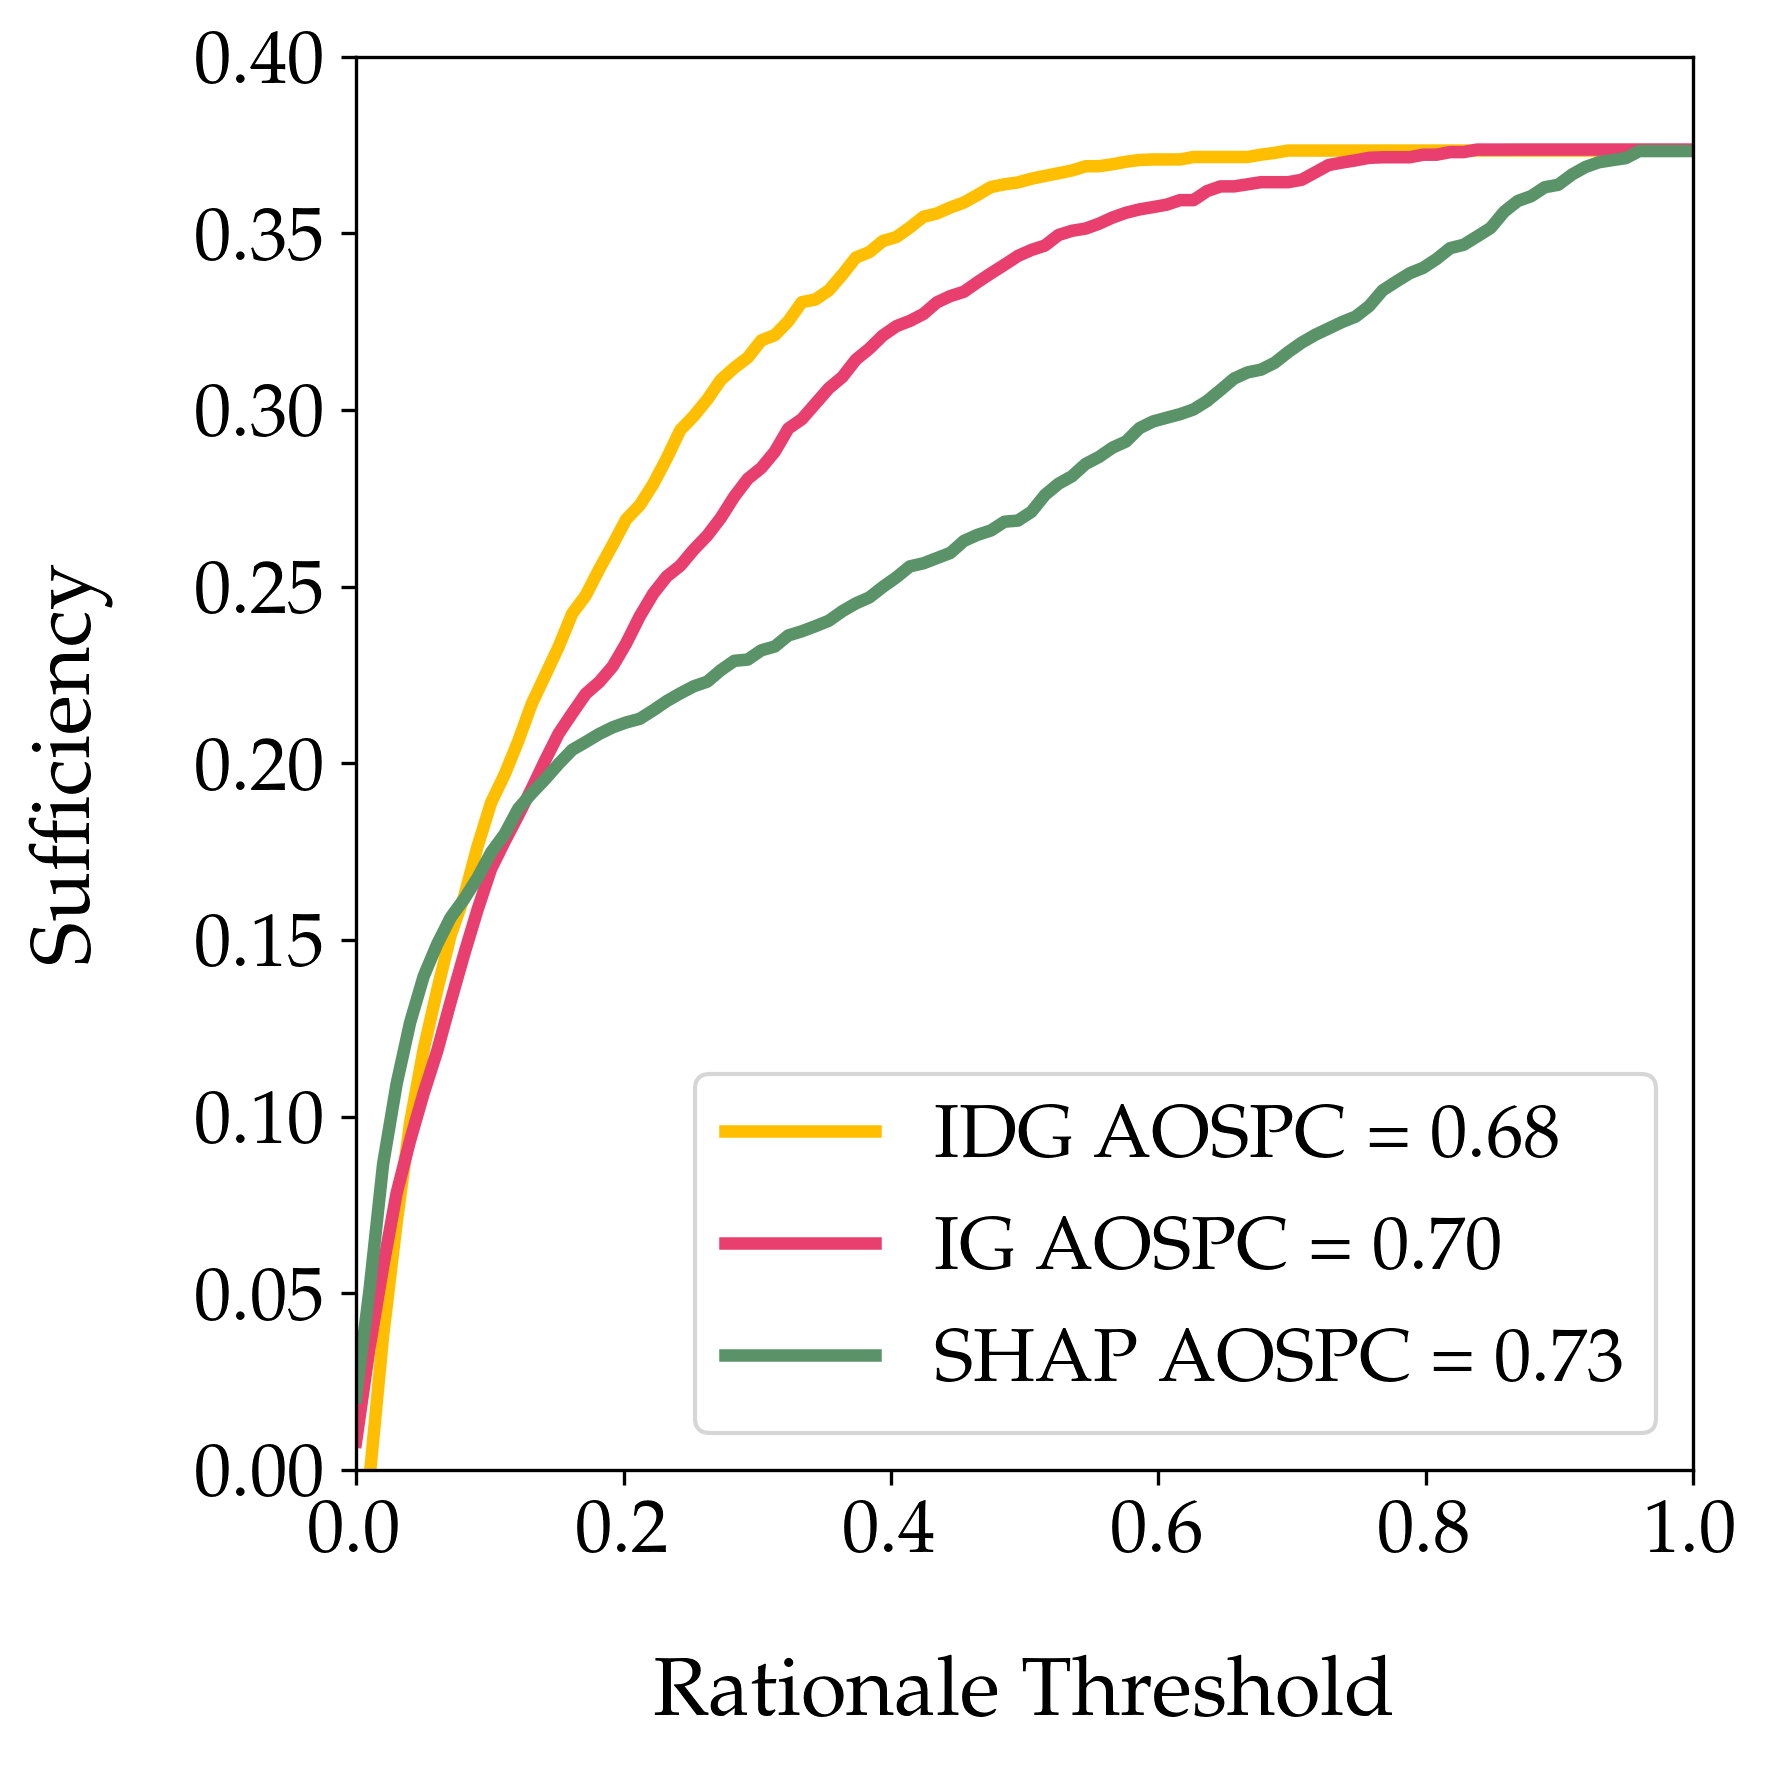

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

ax.plot(
    np.mean(thresholds_idg, axis=0),
    np.mean(sufficiencies_idg, axis=0),
    label=f"IDG AOSPC = {aospc_idg:.2f}",
    color=colors["IDG"],
    lw=3,
)
ax.plot(
    np.mean(thresholds_ig, axis=0),
    np.mean(sufficiencies_ig, axis=0),
    label=f"IG AOSPC = {aospc_ig:.2f}",
    color=colors["IG"],
    lw=3,
)
ax.plot(
    np.mean(thresholds_shap, axis=0),
    np.mean(sufficiencies_shap, axis=0),
    label=f"SHAP AOSPC = {aospc_shap:.2f}",
    color=colors["SHAP"],
    lw=3,
)

ax.legend(fontsize=18)

ax.tick_params(axis="both", which="major", labelsize=18)

ax.set_xlabel(r"Rationale Threshold", fontdict={"size": 20}, labelpad=20)
ax.set_ylabel(r"Sufficiency", fontdict={"size": 20}, labelpad=20)

ax.set_xlim(0, 1)
ax.set_ylim(0, 0.40)


plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "expl_eval" / "eval_sufficiency_1st_order.png",
    bbox_inches="tight",
)


/tmp/ipykernel_51909/3178843015.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


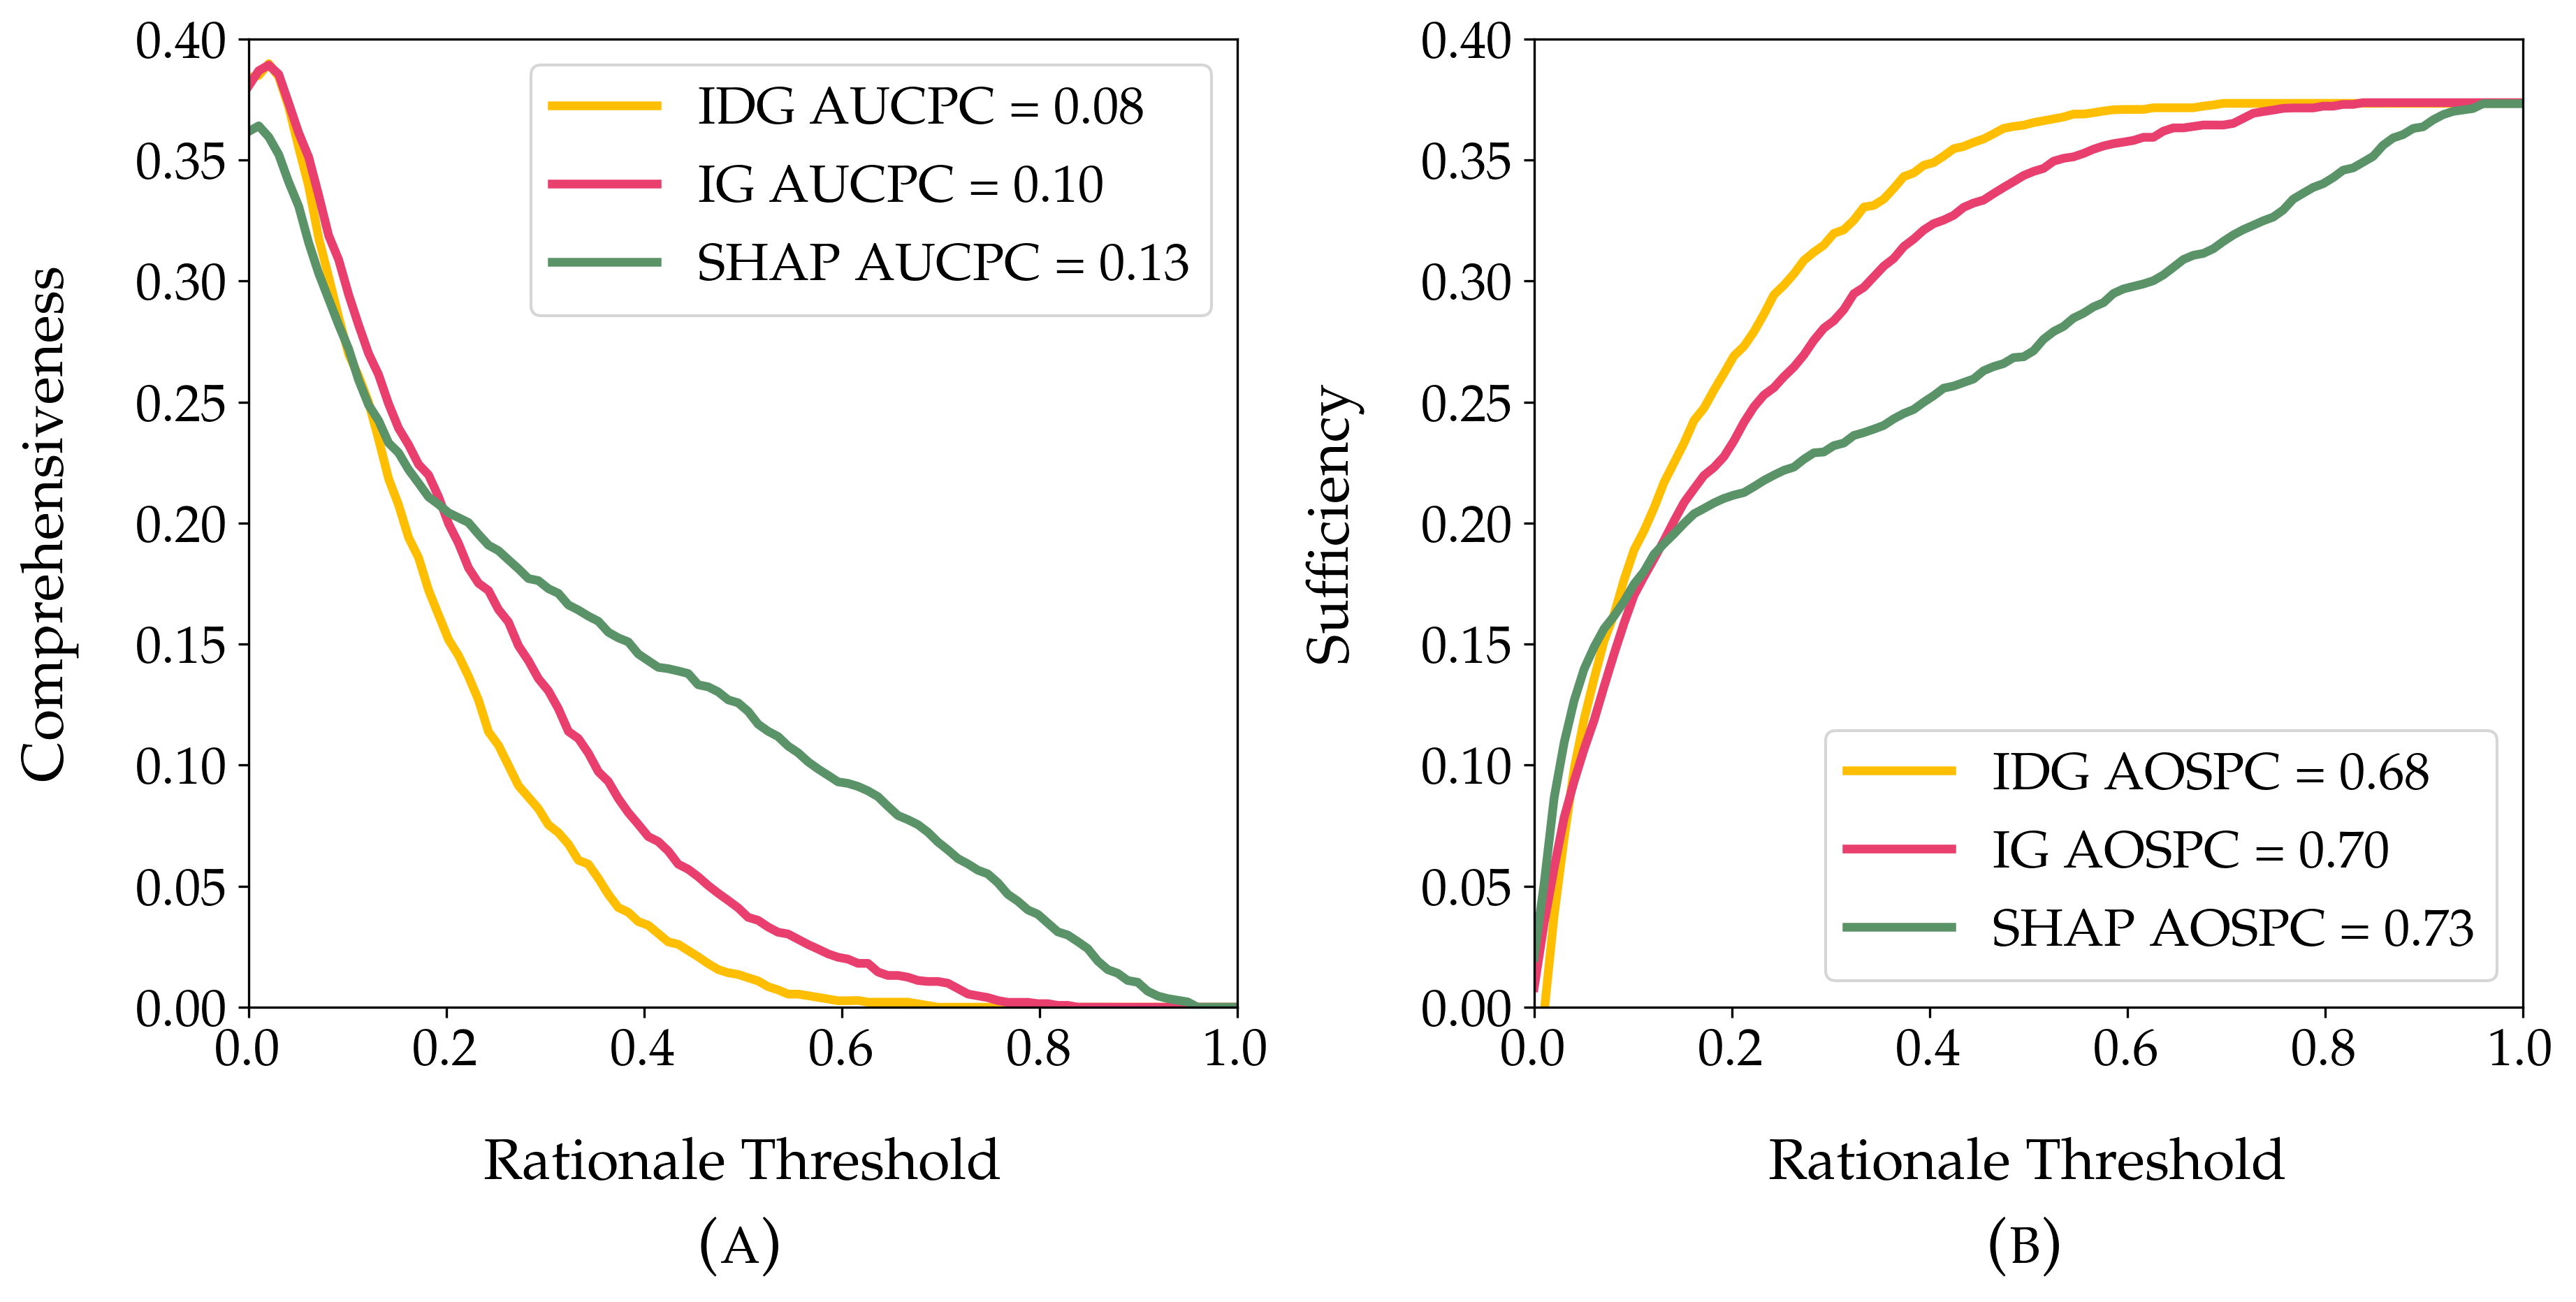

In [ ]:
fig, axs = plt.subplots(
    1, 2,
    figsize=(14, 6),
    dpi=300,
    gridspec_kw={"wspace": 0.3},
    sharex=True,
    # sharey=True,
)


axs[0].plot(
    np.mean(thresholds_idg, axis=0),
    np.mean(comprehensivenesses_idg, axis=0),
    label=f"IDG AUCPC = {aucpc_idg:.2f}",
    color=colors["IDG"],
    lw=3,
)
axs[0].plot(
    np.mean(thresholds_ig, axis=0),
    np.mean(comprehensivenesses_ig, axis=0),
    label=f"IG AUCPC = {aucpc_ig:.2f}",
    color=colors["IG"],
    lw=3,
)
axs[0].plot(
    np.mean(thresholds_shap, axis=0),
    np.mean(comprehensivenesses_shap, axis=0),
    label=f"SHAP AUCPC = {aucpc_shap:.2f}",
    color=colors["SHAP"],
    lw=3,
)

axs[0].legend(fontsize=18)

axs[0].tick_params(axis="both", which="major", labelsize=18)

axs[0].set_xlabel(r"Rationale Threshold", fontdict={"size": 20}, labelpad=20)
axs[0].set_ylabel(r"Comprehensiveness", fontdict={"size": 20}, labelpad=20)

axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 0.40)



axs[1].plot(
    np.mean(thresholds_idg, axis=0),
    np.mean(sufficiencies_idg, axis=0),
    label=f"IDG AOSPC = {aospc_idg:.2f}",
    color=colors["IDG"],
    lw=3,
)
axs[1].plot(
    np.mean(thresholds_ig, axis=0),
    np.mean(sufficiencies_ig, axis=0),
    label=f"IG AOSPC = {aospc_ig:.2f}",
    color=colors["IG"],
    lw=3,
)
axs[1].plot(
    np.mean(thresholds_shap, axis=0),
    np.mean(sufficiencies_shap, axis=0),
    label=f"SHAP AOSPC = {aospc_shap:.2f}",
    color=colors["SHAP"],
    lw=3,
)

axs[1].legend(fontsize=18)

axs[1].tick_params(axis="both", which="major", labelsize=18)

axs[1].set_xlabel(r"Rationale Threshold", fontdict={"size": 20}, labelpad=20)
axs[1].set_ylabel(r"Sufficiency", fontdict={"size": 20}, labelpad=20)

axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 0.40)


axs[0].text(0.5, -.25, r"(\textsc{a})", transform=axs[0].transAxes,
            ha="center", va="center", fontsize=22)
axs[1].text(0.5, -.25, r"(\textsc{b})", transform=axs[1].transAxes,
            ha="center", va="center", fontsize=22)

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "expl_eval" / "eval_faithfulness_comb.png",
    bbox_inches="tight",
)


***

## 8.3. Global Qualitative Evaluation (Word Clouds)

In [ ]:
guids = df_test_trees["post_id"].to_list()
guids = [
    guid for guid in guids if check_label(df_test_trees, guid, label2id["hatespeech"])
]


In [ ]:
stop_words = set(stopwords.words("english"))

word_score_pairs_idg = {}
word_score_pairs_ig = {}
word_score_pairs_shap = {}

for guid in tqdm(guids):
    try:
        # Get the IDG explanation
        idg_expl = get_idg_explanations(IDG_DIR, df_test_trees, guid)
        ig_expl = get_ig_explanations(IG_DIR, df_test_trees, guid)
        shap_expl = get_shap_explanations(SHAP_DIR, df_test_trees, guid)
    except FileNotFoundError:
        print(f"File not found for post {guid}. Skipping...")
        continue
    except ValueError as e:
        print(f"ValueError for post {guid}: {e}.")
        continue

    for token in idg_expl:
        # Remove the positional encoding
        token_ = re.sub(r"\b(\w+)\d+\b", r"\1", token)
        if token_ not in word_score_pairs_idg:
            word_score_pairs_idg[token_] = []
        if idg_expl[token] > 0:
            word_score_pairs_idg[token_].append(idg_expl[token])

    for token in ig_expl:
        # Remove the positional encoding
        token_ = re.sub(r"\b(\w+)\d+\b", r"\1", token)
        if token_ not in word_score_pairs_ig:
            word_score_pairs_ig[token_] = []
        if ig_expl[token] > 0:
            word_score_pairs_ig[token_].append(ig_expl[token])

    for token in ig_expl:
        # Remove the positional encoding
        token_ = re.sub(r"\b(\w+)\d+\b", r"\1", token)
        if token_ not in word_score_pairs_shap:
            word_score_pairs_shap[token_] = []
        if shap_expl[token] > 0:
            word_score_pairs_shap[token_].append(shap_expl[token])


# Remove stop words from the word_score_pairs
word_score_pairs_idg = {
    word: np.mean(scores) if len(scores) > 0 else 0
    for word, scores in word_score_pairs_idg.items()
    if word not in stop_words
}

word_score_pairs_ig = {
    word: np.mean(scores) if len(scores) > 0 else 0
    for word, scores in word_score_pairs_ig.items()
    if word not in stop_words
}

word_score_pairs_shap = {
    word: np.mean(scores) if len(scores) > 0 else 0
    for word, scores in word_score_pairs_shap.items()
    if word not in stop_words
}



  0%|          | 0/594 [00:00<?, ?it/s]

 12%|█▏        | 70/594 [00:00<00:01, 355.34it/s]

ValueError for post 1178251992801533952_twitter: The tokens in the IG values do not match the tokens in the post.
GUID = 1178251992801533952_twitter
Tokens in post:       ['mohammad', 'bin', 'salman', 'al', 'saud', 'ordered', 'the', 'bone', 'sawing', 'of', 'an', 'american', 'journalist', 'i', 'said', 'only', 'thing', 'i1', 'wanna', 'see', 'or', 'hear', 'from', 'that', 'camel', 'jockey', 'prince', 'is', 'screams', 'bone1', 'sawing1', 'him', 'up', 'live', 'on', 't.v.', 'and', 'twitter', 'gives', 'me', '<number>', 'hrs', 'in', 'das', 'hole', 'damn', 'snowflakes']
Tokens in IG values:  ['mohammad', 'bin', 'salman', 'al', 'saud', 'ordered', 'the', 'bone', 'sawing', 'of', 'an', 'american', 'journalist', 'i', 'said', 'only', 'thing', 'i1', 'wanna', 'see', 'or', 'hear', 'from', 'that', 'camel', 'jockey', 'prince', 'is', 'screams', 'bone1', 'sawing1', 'him', 'up', 'live', 'on', 't', '.', 'v', '.1', 'and', 'twitter', 'gives', 'me', '<number>', 'hrs', 'in', 'das', 'hole', 'damn', 'snowflakes'].
V

 20%|█▉        | 118/594 [00:00<00:01, 408.81it/s]

ValueError for post 10177273_gab: The tokens in the IG values do not match the tokens in the post.
GUID = 10177273_gab
Tokens in post:       ['o', 'pleez', 'god', 'hates', 'queers', 'both', '0', 'bamas', 'are', 'male', 'both1', 'have', 'a', 'penis', 'the', 'mooch', 'is', 'a1', 'hideous', 'anti', 'america', 'phony', 'nothin', 'to', 'do', 'with', 'skin', 'color', 'hope', 'mooch1', 'is1', 'jealous', 'of', 'our', 'beautiful', 'lady', 'melania']
Tokens in IG values:  ['o', 'pleez', 'god', 'hates', 'queers', 'both', '', 'bamas', 'are', 'male', 'both1', 'have', 'a', 'penis', 'the', 'mooch', 'is', 'a1', 'hideous', 'anti', 'america', 'phony', 'nothin', 'to', 'do', 'with', 'skin', 'color', 'hope', 'mooch1', 'is1', 'jealous', 'of', 'our', 'beautiful', 'lady', 'melania'].


 41%|████      | 241/594 [00:00<00:01, 296.34it/s]

ValueError for post 22393483_gab: The tokens in the IG values do not match the tokens in the post.
GUID = 22393483_gab
Tokens in post:       ['2', '3', 'andme', 'is', 'a', 'strange', 'choice', 'for', 'this', 'sort', 'of', 'thing', 'given', 'that', 'it', 'primarily', 'works', 'at', 'the', 'behest', 'of1', 'the1', 'israeli', 'government', 'to', 'determine', 'who', 'is1', 'a1', 'kike', 'or', 'not']
Tokens in IG values:  ['', '1', 'andme', 'is', 'a', 'strange', 'choice', 'for', 'this', 'sort', 'of', 'thing', 'given', 'that', 'it', 'primarily', 'works', 'at', 'the', 'behest', 'of1', 'the1', 'israeli', 'government', 'to', 'determine', 'who', 'is1', 'a1', 'kike', 'or', 'not'].
ValueError for post 1177988237765287936_twitter: The tokens in the IG values do not match the tokens in the post.
GUID = 1177988237765287936_twitter
Tokens in post:       ['portrait', 'of', 'a', 'lady', 'on', 'fire', 'screening', 'in', 'atlanta', 'literally', 'the', 'day', 'after', 'i', 'go', 'back', 'home', 'to', 'k*nt

 54%|█████▎    | 318/594 [00:01<00:00, 338.53it/s]

ValueError for post 21446735_gab: The tokens in the IG values do not match the tokens in the post.
GUID = 21446735_gab
Tokens in post:       ['i', 'am', 'a', 'w.a.r.', 'skin', 'do', 'you', 'know', 'john', 'detuillo', 'he', 'doing', 'an', 'l', 'bow', 'for', 'stabbing', 'a1', 'lgbtqwtf', 'in', 'the', 'head', 'and', 'a2', 'mudshark', 'in1', 'the1', 'head1', 'i1', 'used', 'to', 'hang', 'w', 'some', 'american', 'front', 'and1', 'valkyrie', 'front1', 'almost', 'all', 'of', 'them', 'got', 'popped', 'by', 'the2', 'feds', 'on', 'bogus', 'trumoed', 'up', 'charges']
Tokens in IG values:  ['i', 'am', 'a', 'w', '.', 'a1', '.1', 'r', '.2', 'skin', 'do', 'you', 'know', 'john', 'detuillo', 'he', 'doing', 'an', 'l', 'bow', 'for', 'stabbing', 'a2', 'lgbtqwtf', 'in', 'the', 'head', 'and', 'a3', 'mudshark', 'in1', 'the1', 'head1', 'i1', 'used', 'to', 'hang', 'w1', 'some', 'american', 'front', 'and1', 'valkyrie', 'front1', 'almost', 'all', 'of', 'them', 'got', 'popped', 'by', 'the2', 'feds', 'on', 'bogus',

 74%|███████▎  | 437/594 [00:01<00:00, 376.04it/s]

ValueError for post 26551816_gab: The tokens in the IG values do not match the tokens in the post.
GUID = 26551816_gab
Tokens in post:       ['look', 'who', 'introduced', 'theresa', 'may', 'to', 'phillip', 'may1', 'always', 'a', 'connection', 'as', 'to1', 'why', 'paki', 'muslims', 'have', 'raped', 'with', 'impunity', 'g4s', 'protects', 'the', 'grooming', 'gangs', 'that', 'why1', 'tommy', 'robinson', 'has', 'been', 'imprisoned', 'always1', 'a1', 'link']
Tokens in IG values:  ['look', 'who', 'introduced', 'theresa', 'may', 'to', 'phillip', 'may1', 'always', 'a', 'connection', 'as', 'to1', 'why', 'paki', 'muslims', 'have', 'raped', 'with', 'impunity', 'gs', 'protects', 'the', 'grooming', 'gangs', 'that', 'why1', 'tommy', 'robinson', 'has', 'been', 'imprisoned', 'always1', 'a1', 'link'].
ValueError for post 20728328_gab: The tokens in the IG values do not match the tokens in the post.
GUID = 20728328_gab
Tokens in post:       ['4', 'ft', 'tall', 'beaner', 'women', 'still', 'dispensing', '<

 80%|████████  | 476/594 [00:01<00:00, 355.03it/s]

ValueError for post 14311877_gab: The tokens in the IG values do not match the tokens in the post.
GUID = 14311877_gab
Tokens in post:       ['honestly', 'the', 'only', 'woman', 'i', 'would', 'not', 'ever', 'date', 'is', 'a', 'solid', 'black', 'woman1', 'hispanics', 'are', 'aye', 'okay', 'asians', 'are1', 'qu3', '<number>', 'i1', 'do', 'not1', 'have', 'yellow', 'fever', 'anymore', 'but', 'white', 'girls', 'can', 'be', 'crazy', 'ass', 'folk', 'indian', 'and', 'arab', 'women', 'maybe', 'but1', 'they', 'gotta', 'be1', 'shaved', 'no', 'negotiating', 'that', 'shit']
Tokens in IG values:  ['honestly', 'the', 'only', 'woman', 'i', 'would', 'not', 'ever', 'date', 'is', 'a', 'solid', 'black', 'woman1', 'hispanics', 'are', 'aye', 'okay', 'asians', 'are1', 'qu', '<number>', 'i1', 'do', 'not1', 'have', 'yellow', 'fever', 'anymore', 'but', 'white', 'girls', 'can', 'be', 'crazy', 'ass', 'folk', 'indian', 'and', 'arab', 'women', 'maybe', 'but1', 'they', 'gotta', 'be1', 'shaved', 'no', 'negotiating', 

100%|██████████| 594/594 [00:01<00:00, 328.74it/s]

ValueError for post 24146612_gab: The tokens in the IG values do not match the tokens in the post.
GUID = 24146612_gab
Tokens in post:       ['a', 'few', 'years', 'back', 'i', 'talked', 'to', 'my', 'wife', 'about', 'maybe', 'selling', 'our', 'house', 'cashing', 'in', 'our1', '4', '0', '1', 'k', 'and', 'moving', 'our2', 'family', 'to1', 'sweden', 'that', 'out', 'the', 'window', 'we', 'have', '<number>', 'and1', '<number>1', 'yr', 'old', 'beautiful', 'white', 'daughters', 'fucking', 'sand', 'niggers', 'would', 'have1', 'a1', 'hey', 'day', 'with', 'them', 'my1', 'sympathies', 'sweden1']
Tokens in IG values:  ['a', 'few', 'years', 'back', 'i', 'talked', 'to', 'my', 'wife', 'about', 'maybe', 'selling', 'our', 'house', 'cashing', 'in', 'our1', '', '1', '2', 'k', 'and', 'moving', 'our2', 'family', 'to1', 'sweden', 'that', 'out', 'the', 'window', 'we', 'have', '<number>', 'and1', '<number>1', 'yr', 'old', 'beautiful', 'white', 'daughters', 'fucking', 'sand', 'niggers', 'would', 'have1', 'a1', 

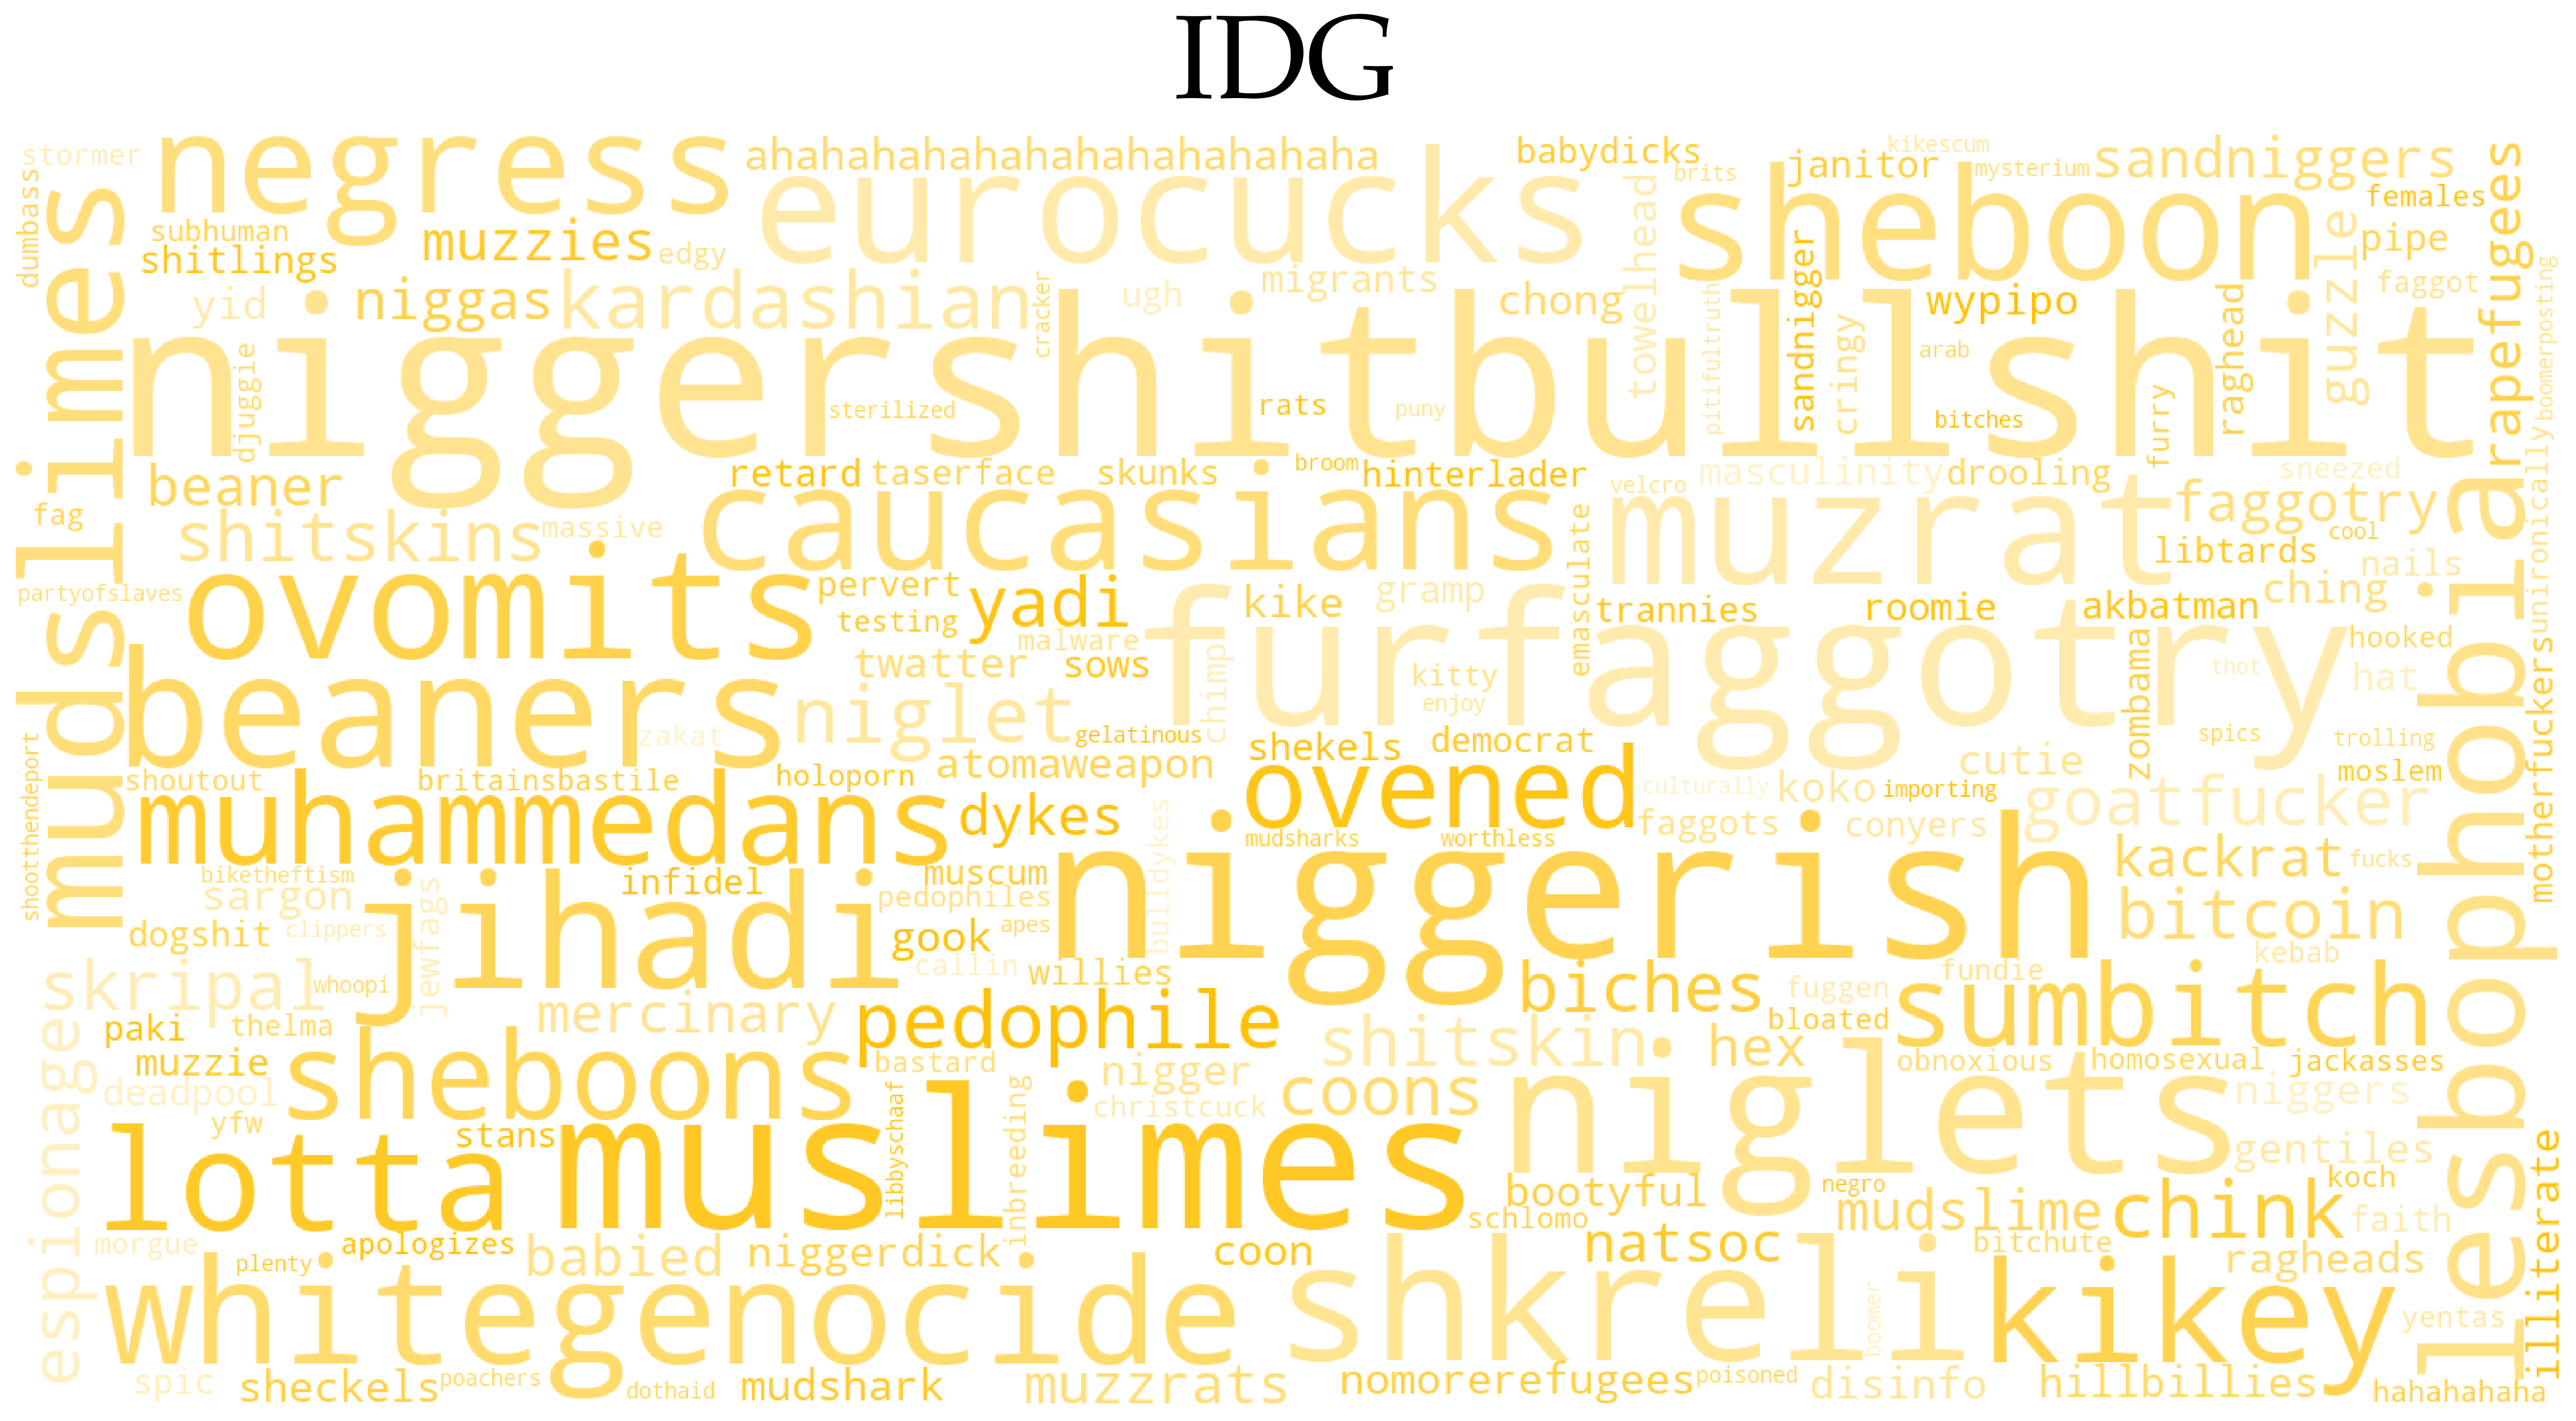

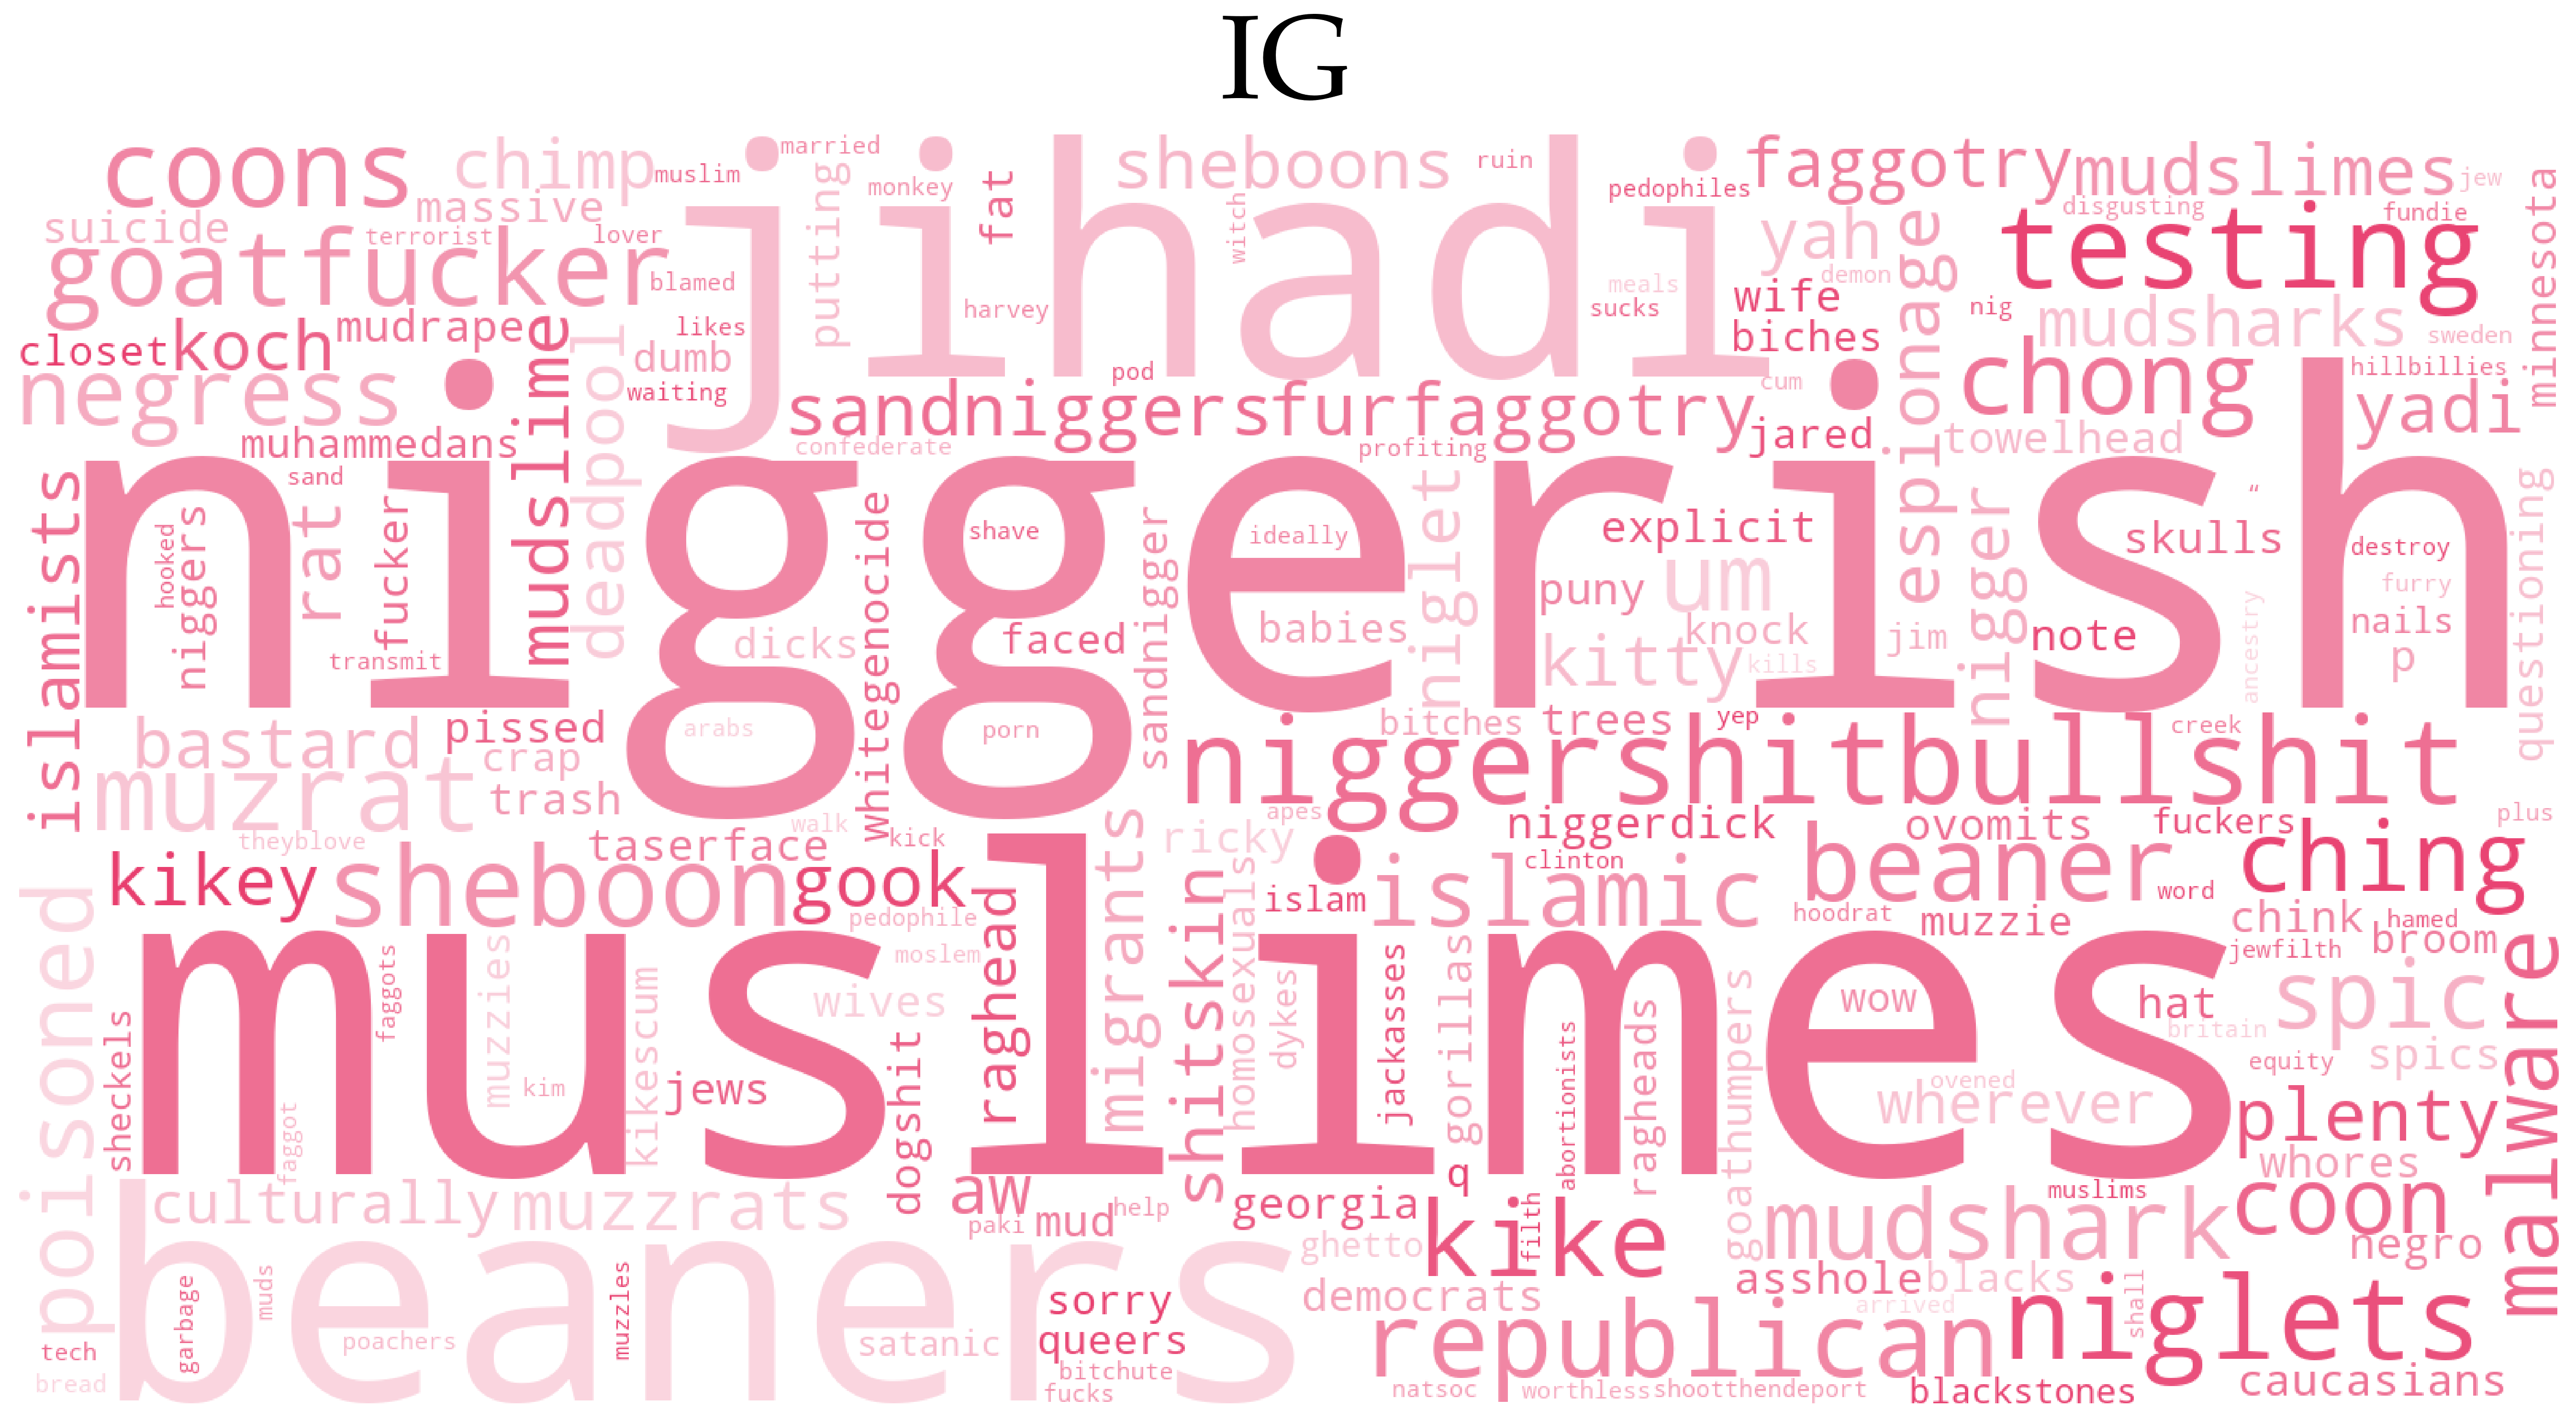

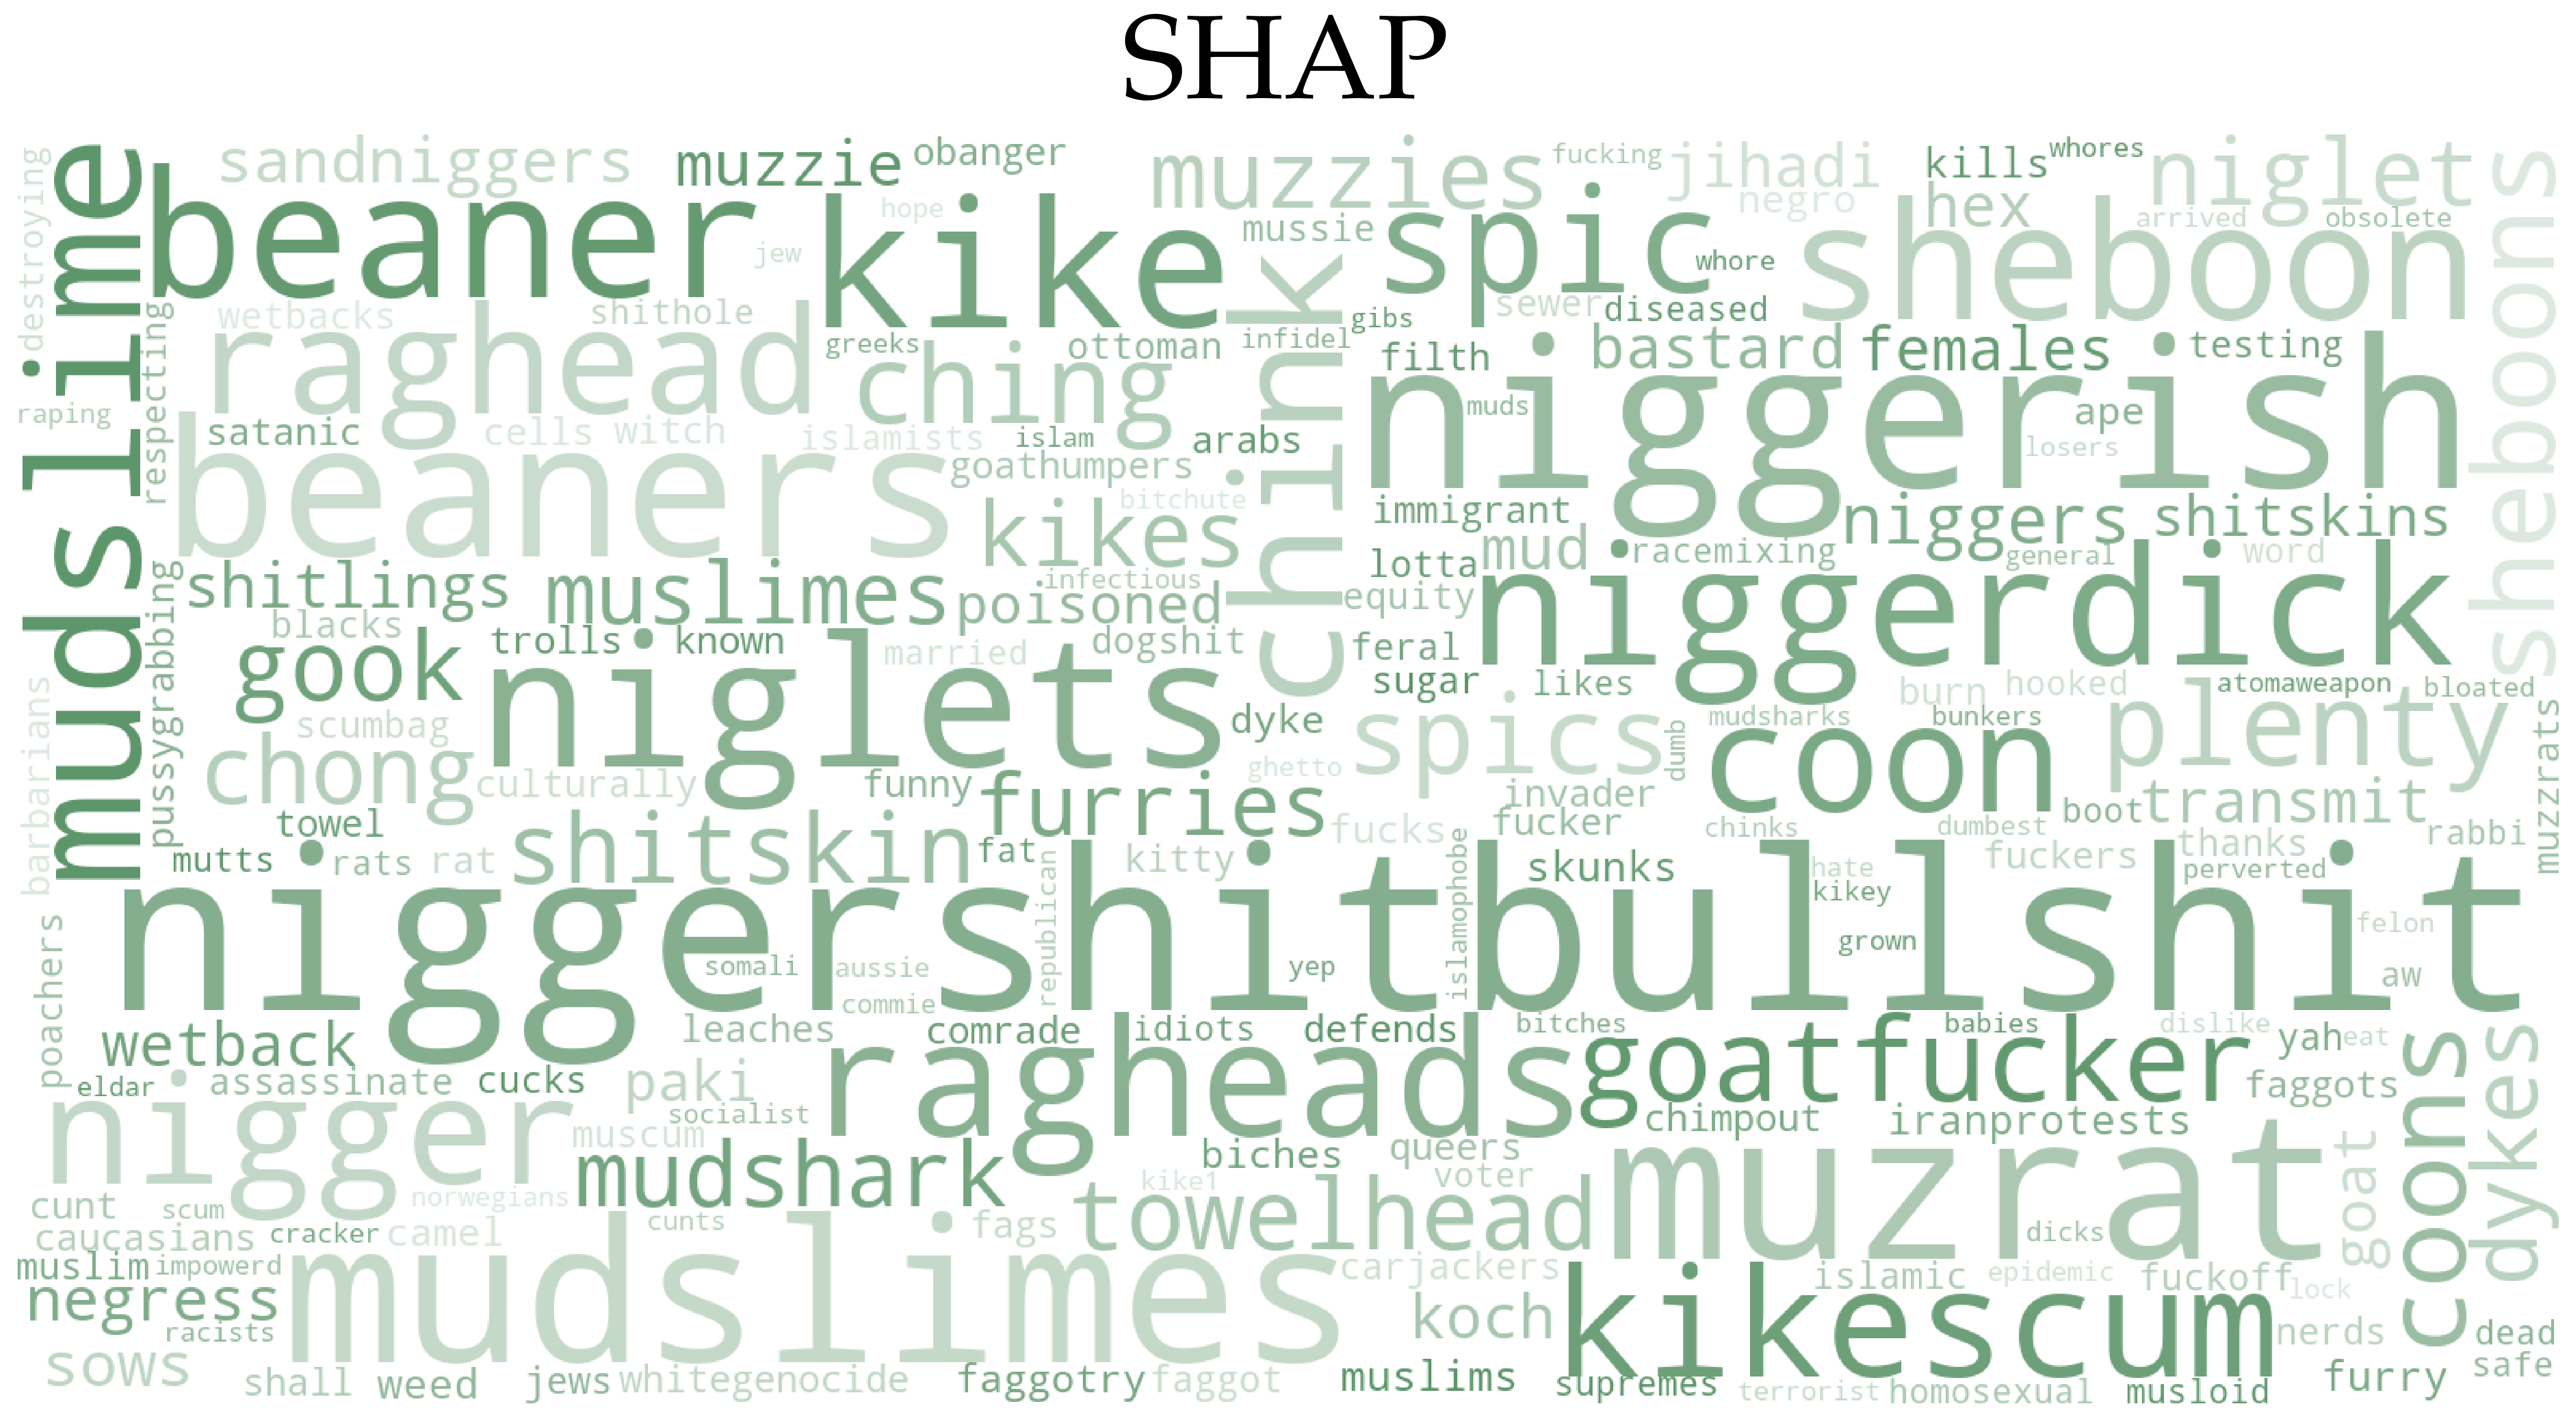

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Create colormaps fading to white for each method
def truncate_colormap(cmap, minval=0.0, maxval=0.8, n=100):
    new_colors = cmap(np.linspace(minval, maxval, n))
    return LinearSegmentedColormap.from_list(cmap.name + "_trunc", new_colors)

idg_full_cmap = LinearSegmentedColormap.from_list("idg_cmap_full", [colors["IDG"], "white"])
idg_cmap = truncate_colormap(idg_full_cmap, 0, 0.8)
ig_cmap = LinearSegmentedColormap.from_list("ig_cmap", [colors["IG"], "white"])
ig_cmap = truncate_colormap(ig_cmap, 0, 0.8)
shap_cmap = LinearSegmentedColormap.from_list("shap_cmap", [colors["SHAP"], "white"])
shap_cmap = truncate_colormap(shap_cmap, 0, 0.8)



wordcloud_idg = WordCloud(
                width=1600, height=800, background_color="white", colormap=idg_cmap,
            ).generate_from_frequencies(
                word_score_pairs_idg,
            )

wordcloud_ig = WordCloud(
                width=1600, height=800, background_color="white", colormap=ig_cmap,
            ).generate_from_frequencies(
                word_score_pairs_ig,
            )
wordcloud_shap = WordCloud(
                width=1600, height=800, background_color="white", colormap=shap_cmap,
            ).generate_from_frequencies(
                word_score_pairs_shap,
            )

fig, ax = plt.subplots(
    figsize=(20, 10),
    dpi=300,
)

ax.imshow(wordcloud_idg)
ax.axis("off")
ax.set_title("IDG", fontsize=60)

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "expl_eval" / "eval_wordcloud_idg.png",
    bbox_inches="tight",
)

fig, ax = plt.subplots(
    figsize=(20, 10),
    dpi=300,
)

ax.imshow(wordcloud_ig)
ax.axis("off")
ax.set_title("IG", fontsize=60)

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "expl_eval" / "eval_wordcloud_ig.png",
    bbox_inches="tight",
)

fig, ax = plt.subplots(
    figsize=(20, 10),
    dpi=300,
)

ax.imshow(wordcloud_shap)
ax.axis("off")
ax.set_title("SHAP", fontsize=60)

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "expl_eval" / "eval_wordcloud_shap.png",
    bbox_inches="tight",
)



In [ ]:
guids = df_test_trees["post_id"].to_list()
guids = [
    guid for guid in guids if check_label(df_test_trees, guid, label2id["hatespeech"])
]


In [ ]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import networkx as nx
import ast

from src.utils.expl_utils import get_attributions_by_level

stop_words = set(stopwords.words("english"))

twogram_score_pairs_idg = {}

for guid in tqdma(guids):
    try:
        # Load the tree
        dot_tree = nx.nx_agraph.read_dot(
            IDG_DIR / f"balanced/{guid}_idg_expl_image_balanced.dot",
        )
    except FileNotFoundError:
        print(f"File not found for guid: {guid}")
        continue

    # Read the tokens
    tokens = df_test_trees.filter(pl.col("post_id") == guid)["tokens"].to_list()[0]

    # Get the attributions by level
    attributions_by_level = get_attributions_by_level(dot_tree, tokens, directionless=False)

    already_seen_pairs_for_guid = set()
    for level, attributions in attributions_by_level.items():
        for token_idxs in attributions:
            token_idxs_ = ast.literal_eval(token_idxs)
            if len(token_idxs_) != 2:
                continue
            token_1 = tokens[token_idxs_[0]]
            token_2 = tokens[token_idxs_[1]]
            token_1 = re.sub(r"\b(\w+)\d+\b", r"\1", token_1)
            token_2 = re.sub(r"\b(\w+)\d+\b", r"\1", token_2)
            if token_1 not in stop_words and token_2 not in stop_words and attributions[token_idxs] > 0:
                if (token_1, token_2) not in twogram_score_pairs_idg:
                    twogram_score_pairs_idg[(token_1, token_2)] = []
                if (token_1, token_2) not in already_seen_pairs_for_guid:
                    twogram_score_pairs_idg[(token_1, token_2)].append(attributions[token_idxs])
                    already_seen_pairs_for_guid.add((token_1, token_2))



  0%|          | 0/594 [00:00<?, ?it/s]

File not found for guid: 10040607_gab
File not found for guid: 14445063_gab


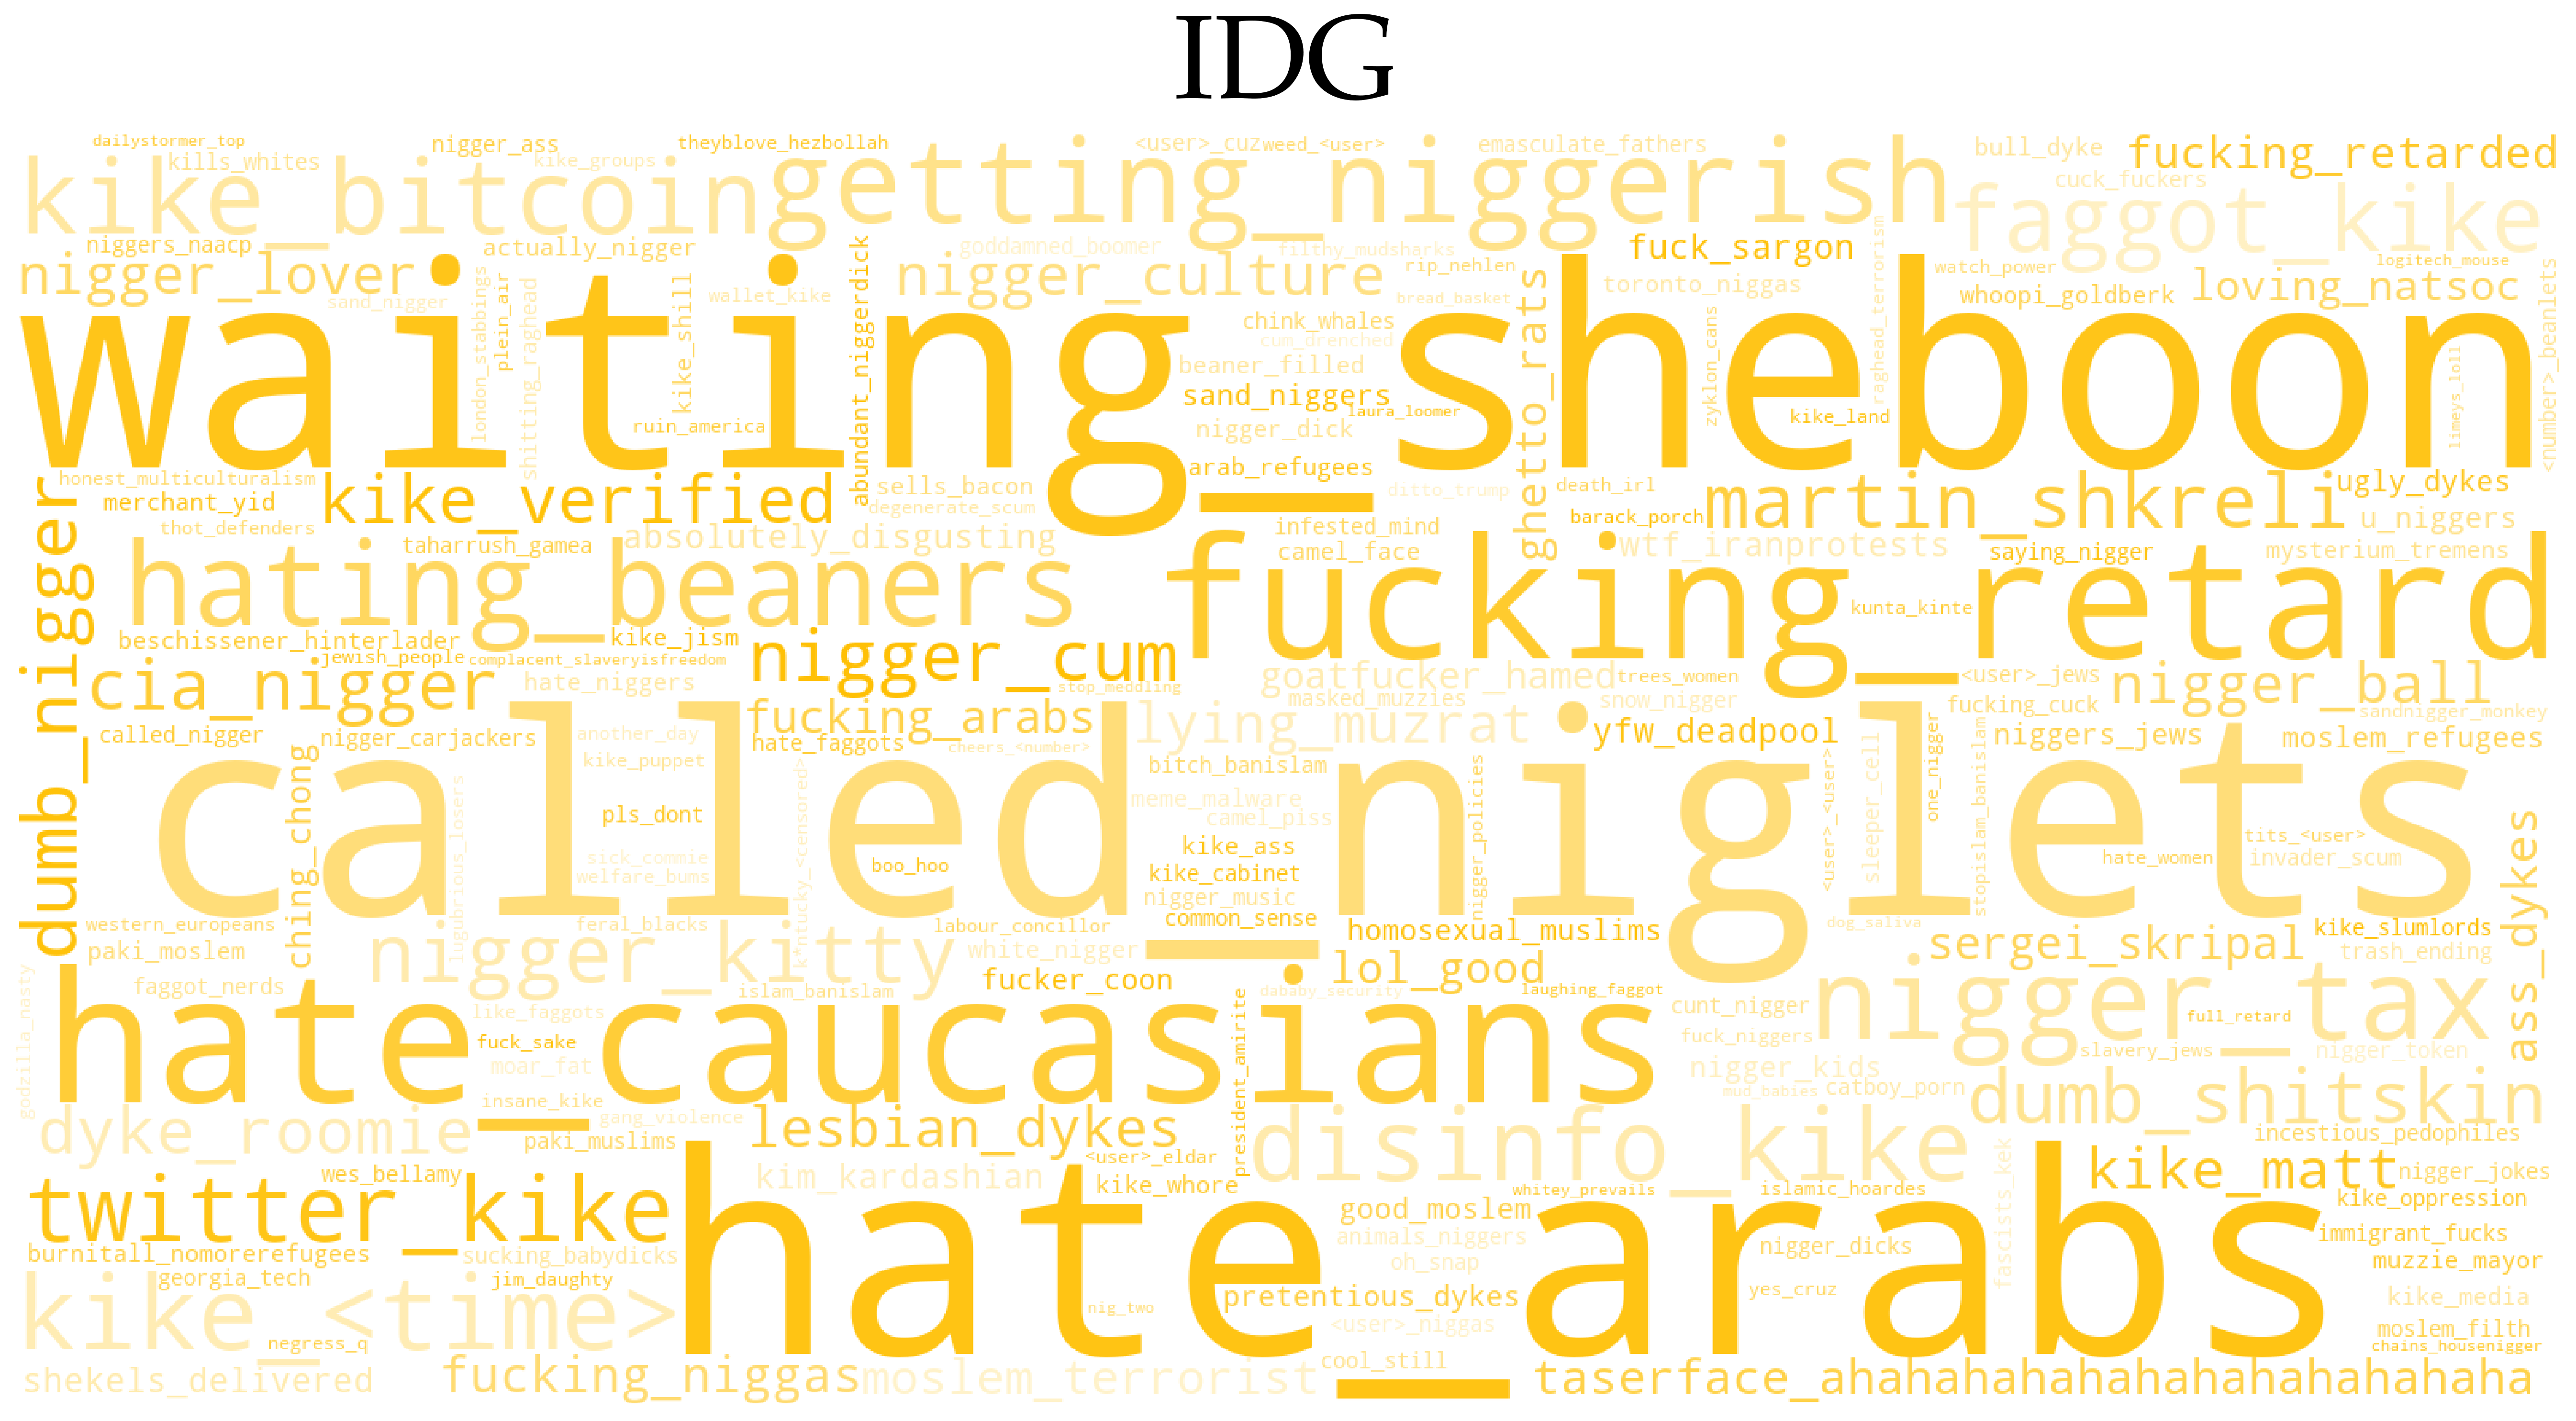

In [ ]:
twogram_score_pairs_idg = {
    f"{word1}_{word2}": np.mean(scores)
    for (word1, word2), scores in twogram_score_pairs_idg.items()
}



wordcloud_idg = WordCloud(
                width=1600, height=800, background_color="white", colormap=idg_cmap,
            ).generate_from_frequencies(
                twogram_score_pairs_idg,
            )

fig, ax = plt.subplots(
    figsize=(20, 10),
    dpi=300,
)

ax.imshow(wordcloud_idg)
ax.axis("off")
ax.set_title("IDG", fontsize=60)

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "expl_eval" / "eval_wordcloud_idg_2grams.png",
    bbox_inches="tight",
)
